# Part 5: Data Wrangling and Exploratory Analysis:
# Overview of the Data

In the prior notebook we were able to create a combined table that linked a negotiated rate to a hospital via a CCN number. We divided this table based on the billing type/code type in order to access the information easier. In the following notebook, we will try to determine which procedures we should compare and combine our CMS metrics with our negotiated rates. In addition, we will begin the creation of some new features that are designed to mimic supply and demand of a hospital.

## Import Libraries

As always, we will import the libraries we intend to work with.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from dotenv import load_dotenv
from datetime import date, datetime, timedelta
import glob
from ast import literal_eval
from collections import Counter
from tqdm.auto import tqdm
import pyarrow as pa
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

### MS-DRG Procedural Billing Type

I believe a good place to begin looking at our data would the MS-DRG file created in our last notebook. This is for a couple of reasons.

DRG codes are usually associated with big surgical procedures and are used for bulk payments (ex. Heart Attack Treatment). These cover all the material/labor/stay for a procedure. Since these are big procedures, I believe insurance companies may have the most incentive to reduce these prices, alongside the CMS, with the hospital. In addition, CMS has a dataset for these procedures (_Medicare_Inpatient_Hospital_by_Provider_and_Service_2020.csv_ located in the _Hospital_Metrics_ folder) for each hospital, we will take a look at these first to see if we can match them with CMS rates. 

From the prior notebook, we will imported dataframes with DRG files. The drg variable are from our private insurance company while the cms variable is price information associated with certain MS-DRG. Let us see if we have enough data to work with here.

In [2]:
drg = pd.read_parquet('D://Vignesh/Capstone/combined/drg_parquet/drg.parquet', engine='pyarrow')
cms = pd.read_csv('Hospital_Metrics/Medicare_Inpatient_Hospital_by_Provider_and_Service_2020.csv', encoding='windows-1252')

Lets take a look at all the billing types that fall under drg in the files that we collected from our prior file.

In [3]:
drg.head()

,billing_type,billing_code,negotiated_rates,ccn
0,MS-DRG,0001,135000.0,050327
1,MS-DRG,0002,135000.0,050327
2,MS-DRG,0003,9000.0,050327
3,MS-DRG,0004,9000.0,050327
4,MS-DRG,0005,135095.0,050327


We can see CCN has 0 in front of the value, same with billing code. For now lets force billing_code as a number and change the type of both of these columns before we merge any files.

In [4]:
drg['billing_code'] = pd.to_numeric(drg['billing_code'],errors='coerce')
drg = drg.astype({'billing_code': 'float','ccn':'int64'})

In [5]:
drg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9777 entries, 0 to 9776
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   billing_type      9777 non-null   object 
 1   billing_code      9762 non-null   float64
 2   negotiated_rates  9777 non-null   float64
 3   ccn               9777 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 305.7+ KB


For now, these types make sense, it is noteworthy that we have some missing billing_code values. Let us double check our header.

In [6]:
drg.head()

,billing_type,billing_code,negotiated_rates,ccn
0,MS-DRG,1.0,135000.0,50327
1,MS-DRG,2.0,135000.0,50327
2,MS-DRG,3.0,9000.0,50327
3,MS-DRG,4.0,9000.0,50327
4,MS-DRG,5.0,135095.0,50327


Our CMS file that we imported contain example DRG from hospitals. We can match on MS-DRG to see relative price differences. Unfortunately, the number of procedures presented are limited for each hospital. Let us take a look at the cms file to see how we can merge these two data sets.

In [7]:
cms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165281 entries, 0 to 165280
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Rndrng_Prvdr_CCN           165281 non-null  int64  
 1   Rndrng_Prvdr_Org_Name      165281 non-null  object 
 2   Rndrng_Prvdr_St            165281 non-null  object 
 3   Rndrng_Prvdr_City          165281 non-null  object 
 4   Rndrng_Prvdr_State_Abrvtn  165281 non-null  object 
 5   Rndrng_Prvdr_State_FIPS    165281 non-null  int64  
 6   Rndrng_Prvdr_Zip5          165281 non-null  int64  
 7   Rndrng_Prvdr_RUCA          165281 non-null  float64
 8   Rndrng_Prvdr_RUCA_Desc     165281 non-null  object 
 9   DRG_Cd                     165281 non-null  int64  
 10  DRG_Desc                   165281 non-null  object 
 11  Tot_Dschrgs                165281 non-null  int64  
 12  Avg_Submtd_Cvrd_Chrg       165281 non-null  float64
 13  Avg_Tot_Pymt_Amt           16

We can change the types to int for both billing code and ccn columns. In order to convert to int, we need to remove NaN values before changing the type.

In [8]:
drg.dropna(subset=['billing_code'],inplace=True)
drg = drg.astype({'billing_code': 'int'})

Lets now merge the two files on CCN and the billing code value. We will do an inner merge to see how many hospitals and procedures are shared among these two tables. 

In [9]:
merged = drg.merge(cms, how='inner', left_on=['ccn','billing_code'], right_on=['Rndrng_Prvdr_CCN','DRG_Cd'])

In [10]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 0 to 798
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   billing_type               799 non-null    object 
 1   billing_code               799 non-null    int32  
 2   negotiated_rates           799 non-null    float64
 3   ccn                        799 non-null    int64  
 4   Rndrng_Prvdr_CCN           799 non-null    int64  
 5   Rndrng_Prvdr_Org_Name      799 non-null    object 
 6   Rndrng_Prvdr_St            799 non-null    object 
 7   Rndrng_Prvdr_City          799 non-null    object 
 8   Rndrng_Prvdr_State_Abrvtn  799 non-null    object 
 9   Rndrng_Prvdr_State_FIPS    799 non-null    int64  
 10  Rndrng_Prvdr_Zip5          799 non-null    int64  
 11  Rndrng_Prvdr_RUCA          799 non-null    float64
 12  Rndrng_Prvdr_RUCA_Desc     799 non-null    object 
 13  DRG_Cd                     799 non-null    int64  

We only have 799 matching payments, and since each procedure widely varies in terms of price, it may be difficult to use without standardizing these payments. In addition we need a variety of hospitals in order to do our analysis, let us take a look at this data a little furthure.

In [11]:
merged.head(10)

,billing_type,billing_code,negotiated_rates,ccn,Rndrng_Prvdr_CCN,Rndrng_Prvdr_Org_Name,Rndrng_Prvdr_St,Rndrng_Prvdr_City,Rndrng_Prvdr_State_Abrvtn,Rndrng_Prvdr_State_FIPS,Rndrng_Prvdr_Zip5,Rndrng_Prvdr_RUCA,Rndrng_Prvdr_RUCA_Desc,DRG_Cd,DRG_Desc,Tot_Dschrgs,Avg_Submtd_Cvrd_Chrg,Avg_Tot_Pymt_Amt,Avg_Mdcr_Pymt_Amt
0,MS-DRG,3,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,3,"""ECMO OR TRACHEOSTOMY WITH MV >96 HOURS OR PRI...",23,1.090380e+06,211395.521740,179499.565220
1,MS-DRG,4,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,4,"TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NE...",18,9.469241e+05,153933.111110,138166.722220
2,MS-DRG,5,135095.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,5,LIVER TRANSPLANT WITH MCC OR INTESTINAL TRANSP...,20,1.083387e+06,143484.300000,129179.250000
3,MS-DRG,11,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,11,"TRACHEOSTOMY FOR FACE, MOUTH & NECK DIAGNOSES ...",12,3.949202e+05,68277.750000,59581.916667
4,MS-DRG,23,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,23,CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACUTE COM...,21,3.829408e+05,66471.142857,59667.809524
5,MS-DRG,25,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,25,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,26,3.617819e+05,50147.307692,45107.153846
6,MS-DRG,27,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,27,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,21,1.635656e+05,26104.333333,23466.095238
7,MS-DRG,64,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,64,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,43,1.982089e+05,26364.906977,21787.767442
8,MS-DRG,65,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,65,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION...,30,8.148413e+04,11613.433333,9173.800000
9,MS-DRG,70,9000.0,50327,50327,Loma Linda University Medical Center,11234 Anderson St,Loma Linda,CA,6,92354,1.0,Metropolitan area core: primary flow within an...,70,NONSPECIFIC CEREBROVASCULAR DISORDERS W MCC,19,1.361019e+05,20190.473684,15949.315789


One thing to note is that all of the payments listed are all from the same medical center, Loma Linda University. Let us take a look at how many unique hospitals are within this merged table.

In [12]:
merged['ccn'].nunique()

15

Only 15 unique hospitals. This number seems way too low to do make a conclusion on whether United Healthcare Insurance is negotiating rates with different hospitals based on CMS metrics or supply and demand metrics. We will need to look at different procedures to make a better conclusion about the data.

## Other Procedure Codes:

It seems with only 15 hospitals and limited procedure types associated with each hospital, we will not be able to use the merged DRG and CMS procedure cost dataset to learn meaningful information about how hospital metrics affect negotiated metrics.

 We can instead pivot to other procedures that are more common and use CMS metrics for hospitals. Here is a table of a list of procedures and CMS metrics they correlate with. I used deduction to determine their correlation. These metrics are explored later in this notebook.

| Code Type | Code Value | Description | Associated CMS Metric | Metric Details
| --- | --- | --- | --- | --- |
| CPT | 36556 | Under Insertion of Central Venous Access Device | HAI_1 | Central Line Associated Bloodstream Infection
| CPT | 51701 | Under Introduction Procedures on the Bladder | HAI_2 | Catheter Associated Urinary Tract Infections
| CPT | 51702 | Under Introduction Procedures on the Bladder | HAI_2 | Catheter Associated Urinary Tract Infections
| HCPCS | A4314 | Insertion tray with drainage bag with indwelling catheter, Foley type, 2-way latex with coating (Teflon, silicone, silicone elastomer or hydrophilic, etc.) | HAI_2 | Catheter Associated Urinary Tract Infections
| HCPCS | A4315 | Insertion tray with drainage bag with indwelling catheter, Foley type, 2-way, all silicone | HAI_2 | Catheter Associated Urinary Tract Infections
| HCPCS | G9312 | Surgical site infection | HAI_3 | Surgical Site Infection - Colon Surgery
| CPT | 58150 | Under Hysterectomy Procedures | HAI_4 | Surgical Site Infection - Abdominal Hysterectomy
| CPT | 15920 | Under Pressure Ulcers (Decubitus Ulcers) Procedures | PSI-3 | Pressure Ulcer Rate
| CPT | 35800 | Under Repair, Excision, Exploration, Revision Procedures on Arteries and Veins | PSI-9 | Postoperative hemorrhage or hematoma rate
| HCPCS | J1650 | Injection, enoxaparin sodium, 10 mg | PSI-12 | Perioperative pulmonary embolism or deep vein thrombosis rate
| HCPCS | C9604 | Percutaneous transluminal revascularization of or through coronary artery bypass graft (internal mammary, free arterial, venous), any combination of drug-eluting intracoronary stent, atherectomy and angioplasty, including distal protection when performed | MORT_30_CABG | Death rate for CABG surgery patients


_PSI 90 is a composite metric of all PSI scores (patient safety scores). Since it should be highly correlated with all surgeries, I believe it would be an appropriate metric to include_

The following are some of the most common CPT codes used within hospital systems, in terms of cost to US hospitals. These do not include procedures like a 15 minute visit to a family practiciner, which I would consider outpatient. I narrowed it down to mostly inpatient procedures, but some of these can be applied to both setting, such as a CBC. I tried to vary the procedures based on expertise of labor, for example dialysis is a more complex procedure vs a comprehensive metabolic panel. 

| Code Type | Code Value | Description |
| --- | --- | --- |
| CPT | 71045 | X-RAY EXAM CHEST 1 VIEW |
| CPT | 99285 | EMERGENCY DEPT VISIT |
| CPT | 85025 | COMPLETE CBC W/AUTO DIFF WBC |
| CPT | 80053 | COMPREHEN METABOLIC PANEL |
| CPT | 90999 | DIALYSIS PROCEDURE |
| CPT | 36415 | ROUTINE VENIPUNCTURE |

In [13]:
code_values = [['CPT','36556'],['CPT','51701'],['CPT','51702'],['HCPCS','A4314'],
                ['HCPCS','A4315'],['HCPCS','G9312'],['CPT','58150'],['CPT','15920'],
                ['CPT','35800'],['HCPCS','J1650'],['HCPCS','C9604'], 
                ['CPT','71045'], ['CPT','99285'], ['CPT','85025'], 
                ['CPT','80053'],['CPT','90999'],['CPT','36415']]

cpt = pd.read_parquet('D:\Vignesh\Capstone\combined\cpt_parquet\cpt.parquet')
hcpcs = pd.read_parquet('D:\Vignesh\Capstone\combined\hcpcs_parquet\hcpcs.parquet')

Similar to the DRG files, lets take a look at the files before we merge dataframes.

In [14]:
cpt.head()

,billing_type,billing_code,negotiated_rates,ccn
0,CPT,0001A,16.94,290003
1,CPT,0001U,576.00,290003
2,CPT,0002A,28.39,290003
3,CPT,0002M,402.72,290003
4,CPT,0002U,20.00,290003


In [15]:
cpt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14771907 entries, 0 to 14771906
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   billing_type      object 
 1   billing_code      object 
 2   negotiated_rates  float64
 3   ccn               object 
dtypes: float64(1), object(3)
memory usage: 450.8+ MB


Since the files we created from the previous notebook are divided into different billing code groups, this for loop will go through both dataframes and collect the rows that match with billing codes we are interested in from the United Healthcare Insurance billing files.


In [16]:
df = pd.DataFrame(columns=['billing_type','billing_code','negotiated_rates','ccn'])

for [code_type, value] in code_values:
    if code_type == 'CPT':
        temp = cpt[cpt['billing_code'] == value]
        df = pd.concat([df,temp], axis=0, ignore_index=True)
    else:
        temp = hcpcs[hcpcs['billing_code'] == value]
        df = pd.concat([df,temp], axis=0, ignore_index=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20208 entries, 0 to 20207
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   billing_type      20208 non-null  object 
 1   billing_code      20208 non-null  object 
 2   negotiated_rates  20208 non-null  float64
 3   ccn               20208 non-null  object 
dtypes: float64(1), object(3)
memory usage: 631.6+ KB


20000+ data set is definitely a good place to start. Let us take a quick look at the header.

In [18]:
df.head()

,billing_type,billing_code,negotiated_rates,ccn
0,CPT,36556,221.30,290003
1,CPT,36556,239.31,290039
2,CPT,36556,92.87,290039
3,CPT,36556,309.82,290003
4,CPT,36556,221.30,290007


We have data points of procedures that we are interested in from United Healthcare dataset. We now need to match these rows with hospital information available from the CMS dataset. 

### Infection Rates

Unfortunately, the CMS file we used earlier within this notebook only had DRG codes and metrics associated with it; however, CMS has hospital metrics. Some of the more key metrics are infection rates associated with different pools of procedures and safety metrics with each hospital. These metrics were shown in the table I created for deciding which procedures we should query within our United Healthcare Insurance dataset. Let us try to merge these files on CCN with the billing information negotiated rates.

There are multiple files with different metrics we can use, these files are CSV files located in the _Hospital_Metrics_ folder. We will first work with infection metrics CMS has for various hospital facilities. Let us load this CSV file and take a preliminary look.

In [19]:
infections = pd.read_csv('Hospital_Metrics\Healthcare_Associated_Infections-Hospital.csv', 
                         usecols=['Facility ID','Measure ID','Score'])
infections.head()

,Facility ID,Measure ID,Score
0,010001,HAI_1_CILOWER,0.289
1,010001,HAI_1_CIUPPER,1.307
2,010001,HAI_1_DOPC,10024
3,010001,HAI_1_ELIGCASES,10.597
4,010001,HAI_1_NUMERATOR,7


The Facility ID is equivalent to CCN. The Measure ID has different metrics recorded for each facility and the score is the indicated value. To merge this dataframe with our negotiated rates, we need to create a pivot table where a single row contains all the metric values for one facility.

In [20]:
inf_piv = infections.pivot(index='Facility ID',columns='Measure ID', values='Score').reset_index()
inf_piv.head()

Measure ID,Facility ID,HAI_1_CILOWER,HAI_1_CIUPPER,HAI_1_DOPC,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_2_CILOWER,HAI_2_CIUPPER,HAI_2_DOPC,...,HAI_5_DOPC,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_5_SIR,HAI_6_CILOWER,HAI_6_CIUPPER,HAI_6_DOPC,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR
0,010001,0.289,1.307,10024,10.597,7,0.661,0.140,0.570,17731,...,101908,9.412,8,0.850,0.492,0.868,101451,72.686,48,0.660
1,010005,1.791,6.741,3713,2.450,9,3.673,0.487,2.498,8670,...,38413,1.999,0,0.000,0.419,1.575,35686,10.484,9,0.858
2,010006,0.307,1.575,7318,7.924,6,0.757,0.050,0.534,11755,...,62709,4.164,6,1.441,0.015,0.292,54159,22.618,2,0.088
3,010007,Not Available,Not Available,268,0.165,0,Not Available,Not Available,Not Available,1417,...,5484,0.132,0,Not Available,0.023,2.296,5413,2.148,1,0.466
4,010008,Not Available,Not Available,14,0.008,0,Not Available,Not Available,Not Available,488,...,2171,0.051,0,Not Available,Not Available,Not Available,2171,0.398,0,Not Available


To ensure that our pivot table contains all the metrics we are interested in, let us take a look at the column of the dataframe. This is a large text file, but it is necessary to insure these match the metrics from the original CSV file.

In [21]:
col = inf_piv.columns.to_list()
col

['Facility ID',
 'HAI_1_CILOWER',
 'HAI_1_CIUPPER',
 'HAI_1_DOPC',
 'HAI_1_ELIGCASES',
 'HAI_1_NUMERATOR',
 'HAI_1_SIR',
 'HAI_2_CILOWER',
 'HAI_2_CIUPPER',
 'HAI_2_DOPC',
 'HAI_2_ELIGCASES',
 'HAI_2_NUMERATOR',
 'HAI_2_SIR',
 'HAI_3_CILOWER',
 'HAI_3_CIUPPER',
 'HAI_3_DOPC',
 'HAI_3_ELIGCASES',
 'HAI_3_NUMERATOR',
 'HAI_3_SIR',
 'HAI_4_CILOWER',
 'HAI_4_CIUPPER',
 'HAI_4_DOPC',
 'HAI_4_ELIGCASES',
 'HAI_4_NUMERATOR',
 'HAI_4_SIR',
 'HAI_5_CILOWER',
 'HAI_5_CIUPPER',
 'HAI_5_DOPC',
 'HAI_5_ELIGCASES',
 'HAI_5_NUMERATOR',
 'HAI_5_SIR',
 'HAI_6_CILOWER',
 'HAI_6_CIUPPER',
 'HAI_6_DOPC',
 'HAI_6_ELIGCASES',
 'HAI_6_NUMERATOR',
 'HAI_6_SIR']

All of these metrics look correct, let us take a look at the data types and how many values we have.

In [22]:
inf_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4848 entries, 0 to 4847
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Facility ID      4848 non-null   object
 1   HAI_1_CILOWER    4848 non-null   object
 2   HAI_1_CIUPPER    4848 non-null   object
 3   HAI_1_DOPC       4848 non-null   object
 4   HAI_1_ELIGCASES  4848 non-null   object
 5   HAI_1_NUMERATOR  4848 non-null   object
 6   HAI_1_SIR        4848 non-null   object
 7   HAI_2_CILOWER    4848 non-null   object
 8   HAI_2_CIUPPER    4848 non-null   object
 9   HAI_2_DOPC       4848 non-null   object
 10  HAI_2_ELIGCASES  4848 non-null   object
 11  HAI_2_NUMERATOR  4848 non-null   object
 12  HAI_2_SIR        4848 non-null   object
 13  HAI_3_CILOWER    4848 non-null   object
 14  HAI_3_CIUPPER    4848 non-null   object
 15  HAI_3_DOPC       4848 non-null   object
 16  HAI_3_ELIGCASES  4848 non-null   object
 17  HAI_3_NUMERATOR  4848 non-null   

There are 4848 hospitals we have infection metrics for. Not all of these values are necessary, so we will edit this dataframe at a later point within this notebook. For now, we will keep all the columns of the dataframe.

### Safety Metrics

We will repeat the above procedure we completed for infection metrics on safety metrics availible from the CMS CSV file _CMS_PSI_6_decimal_file.csv_ in the folder _Hospital_Metrics_.

In [23]:
safety = pd.read_csv('Hospital_Metrics\CMS_PSI_6_decimal_file.csv', 
                         usecols=['Facility ID','Measure ID','Rate'])
safety.head()

,Facility ID,Measure ID,Rate
0,010001,PSI_03,0.231881
1,010001,PSI_06,0.167117
2,010001,PSI_08,0.095461
3,010001,PSI_09,2.330697
4,010001,PSI_10,0.609540


As you can see, we run into the same issue as we did for the infection dataframe. We will have to create a pivot table with the index being CCN or Facility ID, and the columns as Measure ID.

In [24]:
saf_piv = safety.pivot(index='Facility ID',columns='Measure ID',values='Rate').reset_index()
saf_piv.head()

Measure ID,Facility ID,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,PSI_12,PSI_13,PSI_14,PSI_15,PSI_90
0,010001,0.231881,0.167117,0.095461,2.330697,0.609540,8.923957,3.328297,5.980974,0.649012,1.209750,1.005236
1,010005,0.859076,0.173883,0.057663,2.075276,0.756613,6.869380,2.542284,3.440264,0.762277,0.866989,0.908322
2,010006,1.829317,0.261801,0.046622,3.457041,0.651895,3.893786,2.798522,3.721339,0.675144,1.334372,1.099465
3,010007,0.319664,0.183425,0.072035,2.366388,0.914303,6.005962,3.799432,4.048369,Not Available,1.018783,0.993102
4,010008,0.498143,0.185437,0.073861,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available


## Merge Safety and Infection Data

We will merge these files on CCN number(in this case Facility ID). These are currently strings and come from the same dataset, so we will not adjust the data type just yet.

In [25]:
measure = inf_piv.merge(saf_piv, how='inner', on='Facility ID')
measure.head()

Measure ID,Facility ID,HAI_1_CILOWER,HAI_1_CIUPPER,HAI_1_DOPC,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_2_CILOWER,HAI_2_CIUPPER,HAI_2_DOPC,...,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,PSI_12,PSI_13,PSI_14,PSI_15,PSI_90
0,010001,0.289,1.307,10024,10.597,7,0.661,0.140,0.570,17731,...,0.167117,0.095461,2.330697,0.609540,8.923957,3.328297,5.980974,0.649012,1.209750,1.005236
1,010005,1.791,6.741,3713,2.450,9,3.673,0.487,2.498,8670,...,0.173883,0.057663,2.075276,0.756613,6.869380,2.542284,3.440264,0.762277,0.866989,0.908322
2,010006,0.307,1.575,7318,7.924,6,0.757,0.050,0.534,11755,...,0.261801,0.046622,3.457041,0.651895,3.893786,2.798522,3.721339,0.675144,1.334372,1.099465
3,010007,Not Available,Not Available,268,0.165,0,Not Available,Not Available,Not Available,1417,...,0.183425,0.072035,2.366388,0.914303,6.005962,3.799432,4.048369,Not Available,1.018783,0.993102
4,010008,Not Available,Not Available,14,0.008,0,Not Available,Not Available,Not Available,488,...,0.185437,0.073861,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available


Looks like the merge was successful. We can identify some NaN values for certain facility metrics. Let as first take a look at the data types to make sure quantities are a numerical data type.

In [26]:
measure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4813 entries, 0 to 4812
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Facility ID      4813 non-null   object
 1   HAI_1_CILOWER    4813 non-null   object
 2   HAI_1_CIUPPER    4813 non-null   object
 3   HAI_1_DOPC       4813 non-null   object
 4   HAI_1_ELIGCASES  4813 non-null   object
 5   HAI_1_NUMERATOR  4813 non-null   object
 6   HAI_1_SIR        4813 non-null   object
 7   HAI_2_CILOWER    4813 non-null   object
 8   HAI_2_CIUPPER    4813 non-null   object
 9   HAI_2_DOPC       4813 non-null   object
 10  HAI_2_ELIGCASES  4813 non-null   object
 11  HAI_2_NUMERATOR  4813 non-null   object
 12  HAI_2_SIR        4813 non-null   object
 13  HAI_3_CILOWER    4813 non-null   object
 14  HAI_3_CIUPPER    4813 non-null   object
 15  HAI_3_DOPC       4813 non-null   object
 16  HAI_3_ELIGCASES  4813 non-null   object
 17  HAI_3_NUMERATOR  4813 non-null   

Looks like most of the data types are strings instead of a numerical. We will have to adjust this. Let us change these data types for every column to numeric so we can do some comparisons in the future.

In [27]:
col = measure.columns.to_list()
col.remove('Facility ID')
for c in col:
    measure[c] = pd.to_numeric(measure[c],errors='coerce')
measure['Facility ID'] = pd.to_numeric(measure['Facility ID'],errors='coerce')
measure.dropna(subset=['Facility ID'],inplace=True)
measure.drop_duplicates(subset=['Facility ID'],inplace=True)
measure = measure.astype({'Facility ID':'int64'})
types = {c:'float64' for c in col}
measure = measure.astype(types)

We now a table of CMS metrics related to hospital outcomes. Features related to hospital demand and utilization have yet to be added. We will address that next.

### Demand Hospital Data

We also have some data associated with hospital demand. I predetermined which columns to include by looking at the excel spreadsheet. I decided not to include the cost data because it is limited to a short duration and does not align with the year of our United Healthcare Insurance dataset. The metrics I choose should not change to drastically year-to-year. The data includes number of residents, number of beds, number of hospital days, and number of discharges. There are several columns for total hospital days that include pediatric data. Moving forward we may omit this data.

In [28]:
cost = pd.read_csv('Hospital_Metrics\Hospital_Cost_Report_2019.csv', 
                         usecols=['Provider CCN','City', 'State Code', 'Zip Code',
                                'Rural Versus Urban','CCN Facility Type',
                                'Fiscal Year Begin Date', 'Fiscal Year End Date',
                                'Number of Interns and Residents (FTE)', 'Number of Beds',
                                'Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders',
                                'Total Discharges (V + XVIII + XIX + Unknown)',
                                'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
                                'Hospital Total Bed Days Available For Adults &amp; Peds',
                                'Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds'
                                ])
cost.head()

,Provider CCN,City,State Code,Zip Code,Rural Versus Urban,CCN Facility Type,Fiscal Year Begin Date,Fiscal Year End Date,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds
0,40018,VAN BUREN,AR,72956,U,STH,11/01/2018,12/31/2018,NaN,39.0,168.0,481.0,444.0,1891.0,168.0
1,100044,STUART,FL,34995,U,STH,10/01/2018,12/31/2018,NaN,521.0,26952.0,31535.0,26412.0,41124.0,26952.0
2,450090,GAINSVILLE,TX,76240-,R,STH,10/01/2018,11/30/2018,NaN,36.0,175.0,5205.0,534.0,1708.0,175.0
3,40055,FORT SMITH,AR,72901,U,STH,11/01/2018,12/31/2018,4.26,320.0,2077.0,10556.0,9015.0,17629.0,2077.0
4,201302,BOOTHBAY HARBOR,ME,04538-,R,CAH,10/01/2018,12/31/2018,NaN,25.0,382.0,19312.0,1377.0,7665.0,382.0


There is some useful information here, including categorical columns such as rural vs urban. let as take a vertical view and see how many missing values we may have.

In [29]:
cost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6118 entries, 0 to 6117
Data columns (total 15 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Provider CCN                                                                 6118 non-null   int64  
 1   City                                                                         6118 non-null   object 
 2   State Code                                                                   6118 non-null   object 
 3   Zip Code                                                                     6118 non-null   object 
 4   Rural Versus Urban                                                           6049 non-null   object 
 5   CCN Facility Type                                                            6118 non-null   object 
 6   Fiscal Year Begin Date                  

Since the data in this table has dates from which they were collected, some of this data needs to annualized, or at least all converted to the same timer period. In the documentation it is clear that this data can be spread out between 3 months to a year. So lets standardize the data for the time period of one year. Some metrics do not need to be changed, such has number of beds or interns because these stay constant regardless of the time period.

First we will change the types of the data.

In [30]:
cost[['Fiscal Year Begin Date', 'Fiscal Year End Date']]= cost[['Fiscal Year Begin Date', 'Fiscal Year End Date']].apply(pd.to_datetime)
cost['Zip Code'] = cost['Zip Code'].str[:5]
cat = ['City','State Code','Zip Code', 'Rural Versus Urban', 'CCN Facility Type']
types = {c:'category' for c in cat}
cost = cost.astype(types)
cost.head()

,Provider CCN,City,State Code,Zip Code,Rural Versus Urban,CCN Facility Type,Fiscal Year Begin Date,Fiscal Year End Date,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds
0,40018,VAN BUREN,AR,72956,U,STH,2018-11-01,2018-12-31,NaN,39.0,168.0,481.0,444.0,1891.0,168.0
1,100044,STUART,FL,34995,U,STH,2018-10-01,2018-12-31,NaN,521.0,26952.0,31535.0,26412.0,41124.0,26952.0
2,450090,GAINSVILLE,TX,76240,R,STH,2018-10-01,2018-11-30,NaN,36.0,175.0,5205.0,534.0,1708.0,175.0
3,40055,FORT SMITH,AR,72901,U,STH,2018-11-01,2018-12-31,4.26,320.0,2077.0,10556.0,9015.0,17629.0,2077.0
4,201302,BOOTHBAY HARBOR,ME,04538,R,CAH,2018-10-01,2018-12-31,NaN,25.0,382.0,19312.0,1377.0,7665.0,382.0


Lets us create a new column that determines the time period of the collected row.

In [31]:
cost['Time Period'] = cost['Fiscal Year End Date'] - cost['Fiscal Year Begin Date']
cost.head()

,Provider CCN,City,State Code,Zip Code,Rural Versus Urban,CCN Facility Type,Fiscal Year Begin Date,Fiscal Year End Date,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Time Period
0,40018,VAN BUREN,AR,72956,U,STH,2018-11-01,2018-12-31,NaN,39.0,168.0,481.0,444.0,1891.0,168.0,60 days
1,100044,STUART,FL,34995,U,STH,2018-10-01,2018-12-31,NaN,521.0,26952.0,31535.0,26412.0,41124.0,26952.0,91 days
2,450090,GAINSVILLE,TX,76240,R,STH,2018-10-01,2018-11-30,NaN,36.0,175.0,5205.0,534.0,1708.0,175.0,60 days
3,40055,FORT SMITH,AR,72901,U,STH,2018-11-01,2018-12-31,4.26,320.0,2077.0,10556.0,9015.0,17629.0,2077.0,60 days
4,201302,BOOTHBAY HARBOR,ME,04538,R,CAH,2018-10-01,2018-12-31,NaN,25.0,382.0,19312.0,1377.0,7665.0,382.0,91 days


In [32]:
columns_to_convert = ['Total Discharges (V + XVIII + XIX + Unknown)', 'Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders',
                      'Hospital Total Bed Days Available For Adults &amp; Peds',
                      'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
                      'Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds']

for column in columns_to_convert:
    cost[column] = cost[column] * (pd.Timedelta('365 days') / cost['Time Period'])

In [33]:
cost.head()

,Provider CCN,City,State Code,Zip Code,Rural Versus Urban,CCN Facility Type,Fiscal Year Begin Date,Fiscal Year End Date,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Time Period
0,40018,VAN BUREN,AR,72956,U,STH,2018-11-01,2018-12-31,NaN,39.0,1022.000000,2926.083333,2701.000000,11503.583333,1022.000000,60 days
1,100044,STUART,FL,34995,U,STH,2018-10-01,2018-12-31,NaN,521.0,108104.175824,126486.538462,105938.241758,164947.912088,108104.175824,91 days
2,450090,GAINSVILLE,TX,76240,R,STH,2018-10-01,2018-11-30,NaN,36.0,1064.583333,31663.750000,3248.500000,10390.333333,1064.583333,60 days
3,40055,FORT SMITH,AR,72901,U,STH,2018-11-01,2018-12-31,4.26,320.0,12635.083333,64215.666667,54841.250000,107243.083333,12635.083333,60 days
4,201302,BOOTHBAY HARBOR,ME,04538,R,CAH,2018-10-01,2018-12-31,NaN,25.0,1532.197802,77460.219780,5523.131868,30744.230769,1532.197802,91 days


As we can see, some columns have NaN values, for now we will ignore this and address these columns later. For now, let us focus on getting a table put together that we can work with.

In [34]:
cost_measure = measure.merge(cost,how='inner',left_on='Facility ID',right_on='Provider CCN')

We now have a combined both safety metrics and some demand data for each hospital. Lets double check and take a look at the columns.

In [35]:
cost_measure.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4668 entries, 0 to 4667
Data columns (total 64 columns):
 #   Column                                                                       Non-Null Count  Dtype          
---  ------                                                                       --------------  -----          
 0   Facility ID                                                                  4668 non-null   int64          
 1   HAI_1_CILOWER                                                                1896 non-null   float64        
 2   HAI_1_CIUPPER                                                                2098 non-null   float64        
 3   HAI_1_DOPC                                                                   3736 non-null   float64        
 4   HAI_1_ELIGCASES                                                              3736 non-null   float64        
 5   HAI_1_NUMERATOR                                                              3736 non-null

There is some missing data from this table. We will address this later on within this notebook. For now, lets see how many hospitals we are working with.

In [36]:
cost_measure['Facility ID'].nunique() 

4595

We have over 4500+ hospitals we can work with. Let us merge all of our data together. We have the United Healthcare Billing information alongside our hospital data all in one table. Before we can do that, we need to adjust the data type of CCN from our United Healthcare Dataset.

In [37]:
df = df.astype({'ccn':'int64'})
final = df.merge(right=cost_measure,how='inner',left_on='ccn',right_on='Facility ID')
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19779 entries, 0 to 19778
Data columns (total 68 columns):
 #   Column                                                                       Non-Null Count  Dtype          
---  ------                                                                       --------------  -----          
 0   billing_type                                                                 19779 non-null  object         
 1   billing_code                                                                 19779 non-null  object         
 2   negotiated_rates                                                             19779 non-null  float64        
 3   ccn                                                                          19779 non-null  int64          
 4   Facility ID                                                                  19779 non-null  int64          
 5   HAI_1_CILOWER                                                                15260 non-n

In [38]:
final.describe()

,negotiated_rates,ccn,Facility ID,HAI_1_CILOWER,HAI_1_CIUPPER,HAI_1_DOPC,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_2_CILOWER,...,PSI_90,Provider CCN,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Time Period
count,19779.000000,19779.000000,19779.000000,15260.00000,16163.000000,19407.000000,19407.000000,19407.000000,16163.000000,15967.000000,...,18447.000000,19779.000000,9953.000000,19779.000000,19779.000000,19779.000000,19760.000000,19760.000000,19779.000000,19779
mean,2480.240888,194610.881794,194610.881794,0.52568,2.002382,12434.313650,12.910460,12.576235,0.985094,0.408412,...,0.987983,194610.881794,129.314692,346.960716,18270.115001,105131.283337,68381.652201,102070.072293,18270.115001,360 days 16:55:50.462611864
std,41772.468869,150512.000021,150512.000021,0.45294,1.187761,15914.518236,17.612264,20.002346,0.695172,0.334570,...,0.211000,150512.000021,185.602377,407.207628,21928.491647,120881.925927,85455.607387,120130.968787,21928.491647,30 days 13:44:45.237617519
min,0.300000,10001.000000,10001.000000,0.00400,0.403000,4.000000,0.001000,0.000000,0.000000,0.003000,...,0.497610,10001.000000,0.080000,2.000000,18.049451,449.000000,37.101648,732.005495,18.049451,61 days 00:00:00
25%,14.775000,60113.000000,60113.000000,0.21400,1.255000,2945.000000,2.414000,1.000000,0.561000,0.160000,...,0.848353,60113.000000,16.890000,124.000000,5703.000000,36815.865385,18056.469780,36600.000000,5703.000000,364 days 00:00:00
50%,61.000000,100287.000000,100287.000000,0.42600,1.633000,6995.000000,6.365000,6.000000,0.863000,0.320000,...,0.959044,100287.000000,44.080000,236.000000,12725.000000,67098.832418,44492.000000,72102.541209,12725.000000,364 days 00:00:00
75%,297.315000,300001.000000,300001.000000,0.76800,2.387000,14746.000000,15.166000,15.000000,1.257000,0.605000,...,1.082976,300001.000000,166.050000,410.000000,22906.758242,123082.000000,82959.285714,120729.000000,22906.758242,365 days 00:00:00
max,999999.990000,670076.000000,670076.000000,4.08100,11.146000,89310.000000,95.144000,118.000000,5.869000,2.211000,...,2.017952,670076.000000,1285.530000,2735.000000,131197.445055,815529.326923,538474.271978,821676.167582,131197.445055,365 days 00:00:00


We have some repeated values alongside values we do not need to consider anymore. Let us get rid of columns that are redundant to CCN and since we have already annualized our data, we will remove the time period column.

In [39]:
final.drop(columns=['Facility ID', 'Provider CCN', 'Time Period'], inplace=True)
final['Procedure'] = final['billing_type'] + ' ' + final['billing_code']

Let us take a look at our final list of columns and make everything is available that we intend to use.

In [40]:
col = final.columns.to_list()
col

['billing_type',
 'billing_code',
 'negotiated_rates',
 'ccn',
 'HAI_1_CILOWER',
 'HAI_1_CIUPPER',
 'HAI_1_DOPC',
 'HAI_1_ELIGCASES',
 'HAI_1_NUMERATOR',
 'HAI_1_SIR',
 'HAI_2_CILOWER',
 'HAI_2_CIUPPER',
 'HAI_2_DOPC',
 'HAI_2_ELIGCASES',
 'HAI_2_NUMERATOR',
 'HAI_2_SIR',
 'HAI_3_CILOWER',
 'HAI_3_CIUPPER',
 'HAI_3_DOPC',
 'HAI_3_ELIGCASES',
 'HAI_3_NUMERATOR',
 'HAI_3_SIR',
 'HAI_4_CILOWER',
 'HAI_4_CIUPPER',
 'HAI_4_DOPC',
 'HAI_4_ELIGCASES',
 'HAI_4_NUMERATOR',
 'HAI_4_SIR',
 'HAI_5_CILOWER',
 'HAI_5_CIUPPER',
 'HAI_5_DOPC',
 'HAI_5_ELIGCASES',
 'HAI_5_NUMERATOR',
 'HAI_5_SIR',
 'HAI_6_CILOWER',
 'HAI_6_CIUPPER',
 'HAI_6_DOPC',
 'HAI_6_ELIGCASES',
 'HAI_6_NUMERATOR',
 'HAI_6_SIR',
 'PSI_03',
 'PSI_06',
 'PSI_08',
 'PSI_09',
 'PSI_10',
 'PSI_11',
 'PSI_12',
 'PSI_13',
 'PSI_14',
 'PSI_15',
 'PSI_90',
 'City',
 'State Code',
 'Zip Code',
 'Rural Versus Urban',
 'CCN Facility Type',
 'Fiscal Year Begin Date',
 'Fiscal Year End Date',
 'Number of Interns and Residents (FTE)',
 'Number o

## Cleaning

We are going to remove some columns that are redundant. For example each PSI metric is broken down into its component parts in the original CMS table. We will just work with the final score given to each PSI value. This can also be used in the HAI score.

In [41]:
col_work = ['ccn', 
            'Procedure',
            'State Code',
            'Rural Versus Urban',
            'PSI_03',
            'PSI_06',
            'PSI_08',
            'PSI_09',
            'PSI_10',
            'PSI_11',
            'PSI_12',
            'PSI_13',
            'PSI_14',
            'PSI_15',
            'PSI_90',
            'HAI_1_SIR',
            'HAI_2_SIR',
            'HAI_3_SIR',
            'HAI_4_SIR',
            'HAI_5_SIR',
            'HAI_6_SIR',
            'Number of Interns and Residents (FTE)',
            'Number of Beds',
            'Total Discharges (V + XVIII + XIX + Unknown)',
            'Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders',
            'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
            'Hospital Total Bed Days Available For Adults &amp; Peds',
            'Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds',
            'negotiated_rates']
df = final[col_work]
df.head()

,ccn,Procedure,State Code,Rural Versus Urban,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,...,HAI_5_SIR,HAI_6_SIR,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,negotiated_rates
0,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,221.30
1,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,309.82
2,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,273.50
3,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,106.14
4,290003,CPT 36556,NV,U,0.13266,0.184709,0.114236,1.56662,0.650623,9.818181,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,171.56


In [42]:
df.info()
df = df.astype({'ccn':'category', 'Procedure':'category'})

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19779 entries, 0 to 19778
Data columns (total 29 columns):
 #   Column                                                                       Non-Null Count  Dtype   
---  ------                                                                       --------------  -----   
 0   ccn                                                                          19779 non-null  int64   
 1   Procedure                                                                    19779 non-null  object  
 2   State Code                                                                   19779 non-null  category
 3   Rural Versus Urban                                                           19779 non-null  category
 4   PSI_03                                                                       18574 non-null  float64 
 5   PSI_06                                                                       18574 non-null  float64 
 6   PSI_08                        

As we can see from these columns there are several missing values, and we need to know what to do with these. Let us first remove columns that have over 50% missing values: Number of Interns and Residents (FTE) and HAI_4_SIR; however, Number of Interns and Residents (FTE) is missing because the values that are missing are usually 0. So we will convert that column to 0.

For other columns we will fill the NaN values with the mean of the non-missing rows.

In [43]:
missing_mean = ['PSI_03', 'PSI_06', 'PSI_08', 'PSI_09', 'PSI_10', 'PSI_11', 'PSI_12', 'PSI_13', 'PSI_14', 'PSI_15', 'PSI_90',
                'HAI_1_SIR', 'HAI_2_SIR', 'HAI_3_SIR', 'HAI_5_SIR', 'HAI_6_SIR',
                'Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds', 
                'Hospital Total Bed Days Available For Adults &amp; Peds']
missing_zero = ['Number of Interns and Residents (FTE)']
remove = ['HAI_4_SIR']

Let us take a quick look at the boxplot where the x axis is the procedures and y axis is negotiated rates to look for outliers.

<Axes: xlabel='Procedure', ylabel='negotiated_rates'>

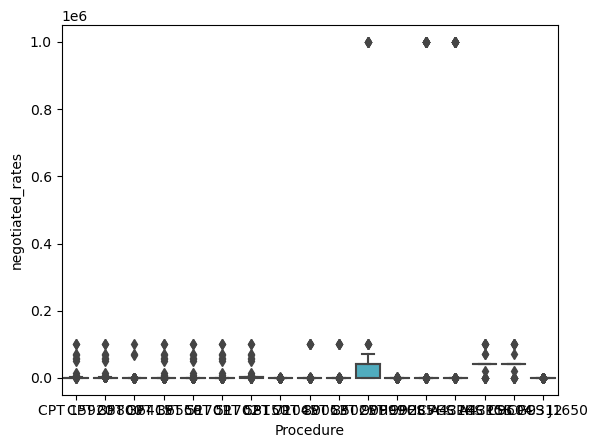

In [44]:
sns.boxplot(x="Procedure", y="negotiated_rates",
            data=df)

There definately seem to be some outliers present, lets take a close look at this.

In [45]:
df2 = df.groupby(['Procedure'])['negotiated_rates']

In [46]:
df2.describe()

,count,mean,std,min,25%,50%,75%,max
Procedure,,,,,,,,
CPT 15920,1385.0,1193.742116,5277.226813,0.57,600.5000,754.810,982.4800,99999.00
CPT 35800,1373.0,1298.682251,5300.364988,0.57,635.8100,851.470,1116.7900,99999.00
CPT 36415,929.0,262.645188,4611.965008,0.30,1.8000,3.000,4.2400,99999.00
CPT 36556,1856.0,563.168260,4586.026572,0.57,160.8900,251.830,343.3925,99999.00
CPT 51701,1860.0,344.716629,4588.884211,0.57,37.2875,54.245,74.9500,99999.00
CPT 51702,1864.0,361.296196,4583.017383,0.57,40.4000,73.760,100.7500,99999.00
CPT 58150,1386.0,1748.699149,5266.192033,0.57,1021.1125,1260.930,1604.5450,99999.00
CPT 71045,2605.0,21.837259,58.435802,0.57,10.3600,17.020,25.9800,2897.00
CPT 80053,1050.0,395.139533,6163.078289,0.87,6.2000,8.620,14.6100,99999.99


So it looks like most procedures have some outlier values, particular at the higher cost end. Lets try to rid us of these points but working with the data that lies between 5%-95%.

We are going to create a dictionary there each entry is a table allocated by procedure. We can then view each of these boxplots independently and see if the data contains outliers and learn more about each procedure and their prices. We ultimately may choose to narrow down our procedures based on what we learn about the price ranges in are United Healthcare dataset.

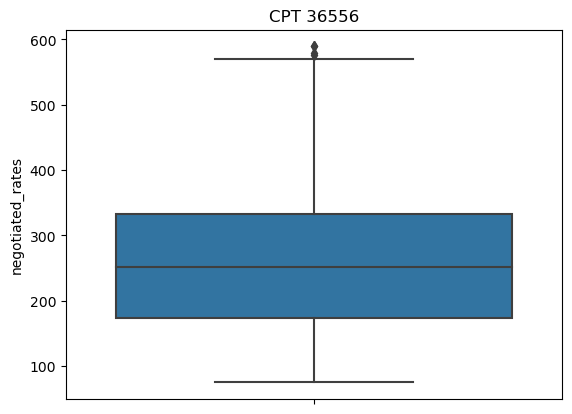

1671/1856 data points remain for CPT 36556.


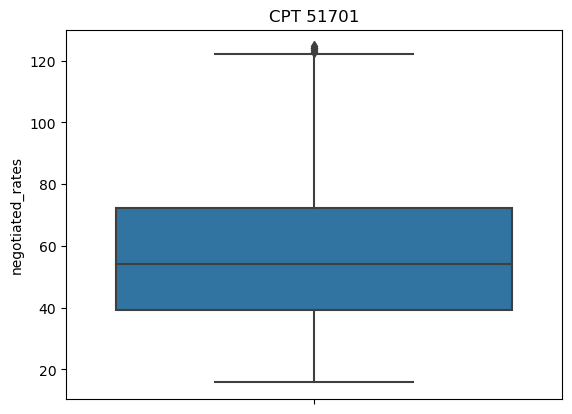

1674/1860 data points remain for CPT 51701.


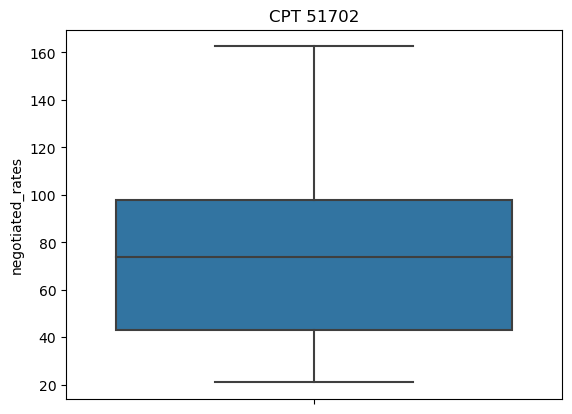

1676/1864 data points remain for CPT 51702.


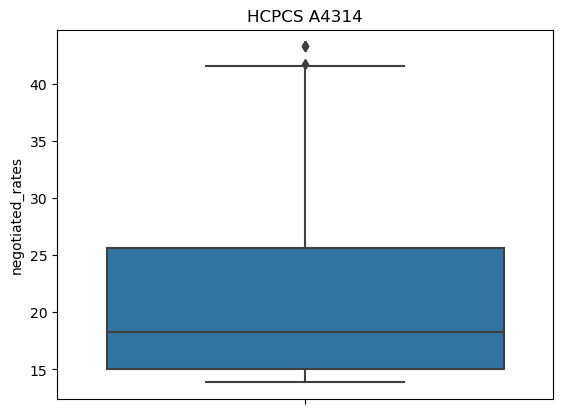

787/872 data points remain for HCPCS A4314.


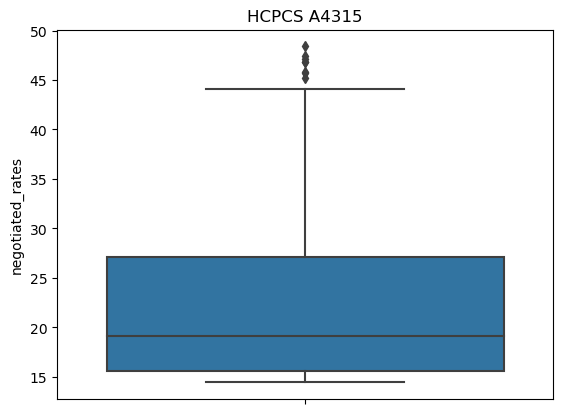

784/869 data points remain for HCPCS A4315.


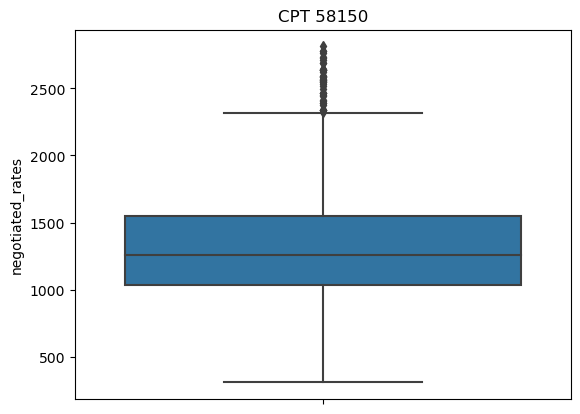

1248/1386 data points remain for CPT 58150.


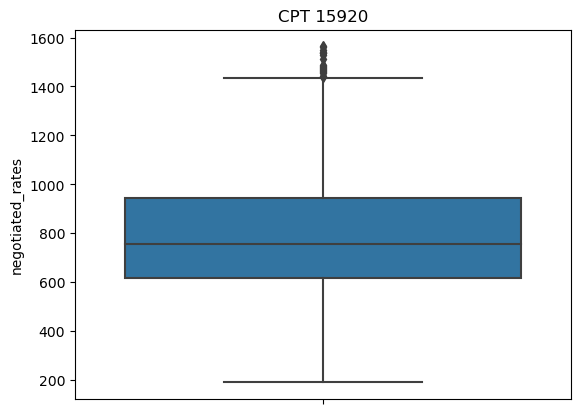

1245/1385 data points remain for CPT 15920.


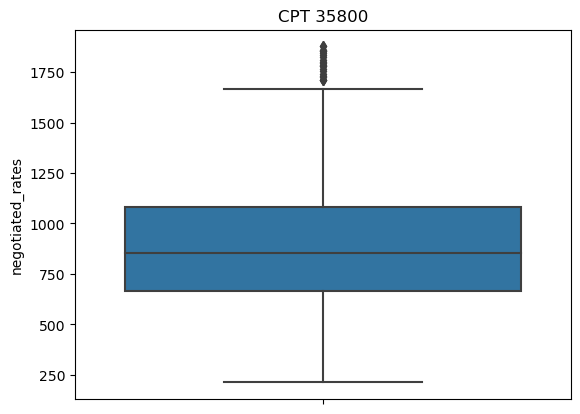

1235/1373 data points remain for CPT 35800.


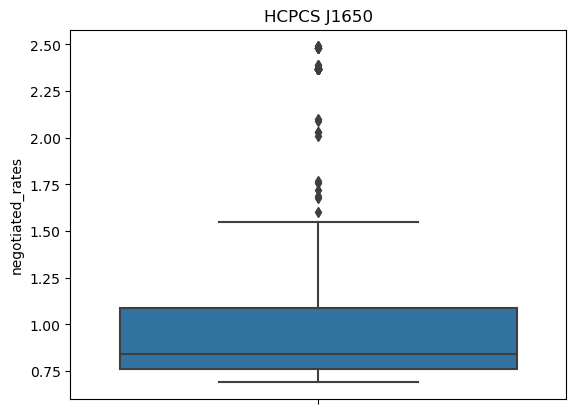

646/711 data points remain for HCPCS J1650.


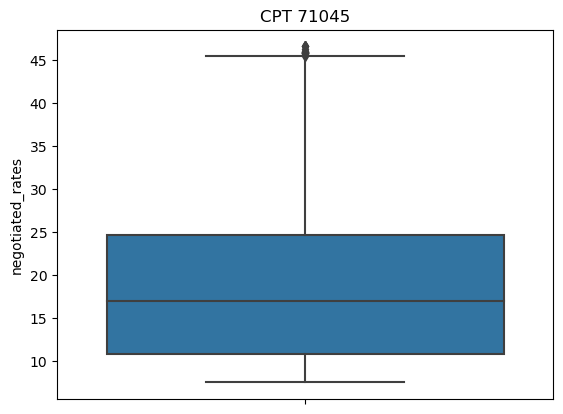

2345/2605 data points remain for CPT 71045.


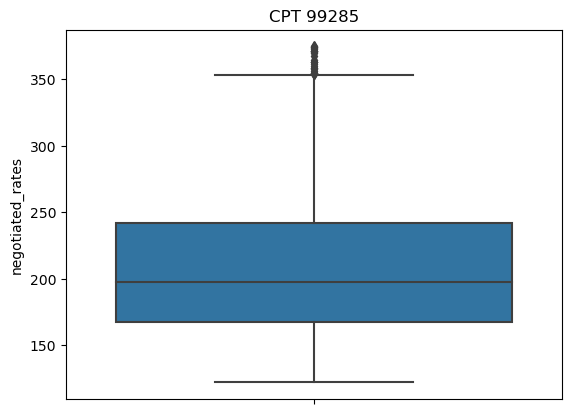

1604/1784 data points remain for CPT 99285.


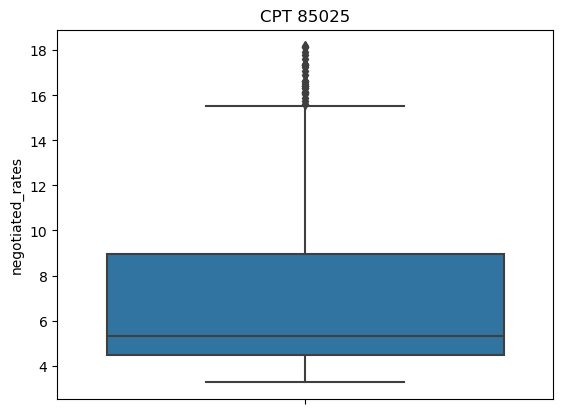

1008/1077 data points remain for CPT 85025.


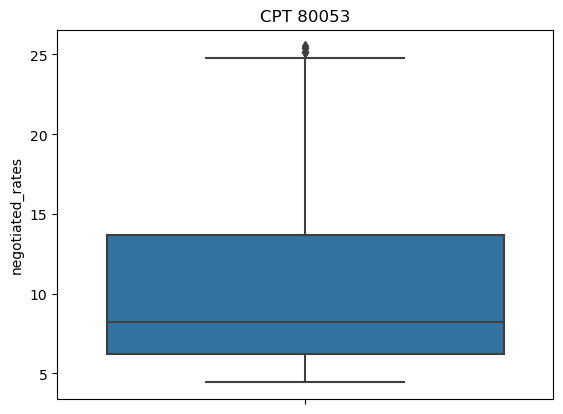

978/1050 data points remain for CPT 80053.


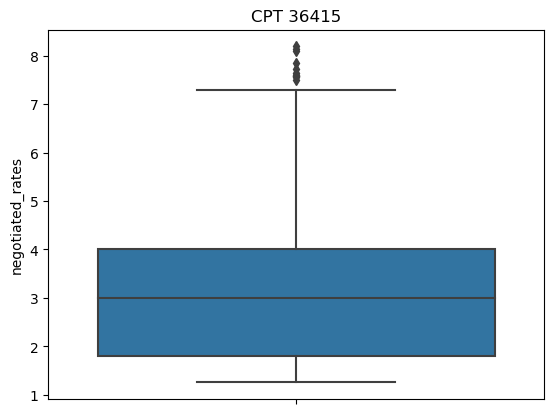

853/929 data points remain for CPT 36415.


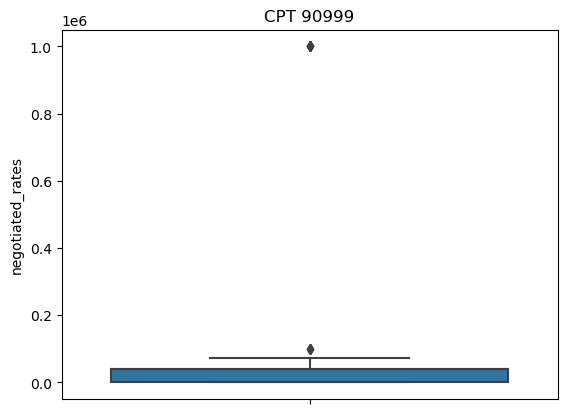

65/68 data points remain for CPT 90999.


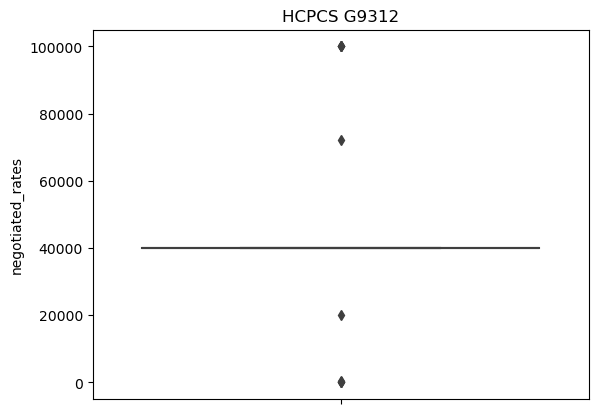

41/44 data points remain for HCPCS G9312.


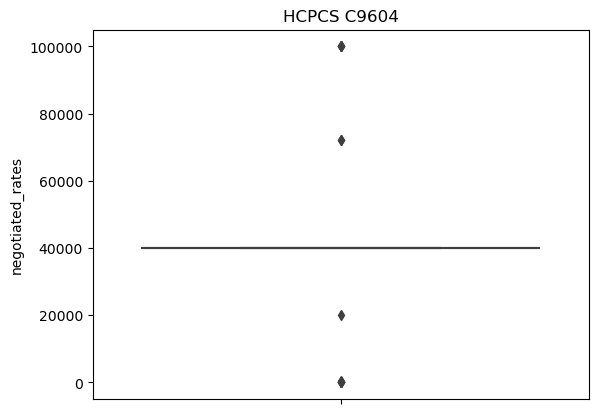

44/46 data points remain for HCPCS C9604.


In [47]:
procedures = df['Procedure'].unique()
df_dict = {}
for p in procedures:
    df_temp = df[df['Procedure'] == p].reset_index()
    temp = df_temp['negotiated_rates']
    plt.figure()
    ro = temp.between(temp.quantile(.05), temp.quantile(.95))
    index_names = df_temp[~ro].index
    df_temp.drop(index_names, inplace=True)
    sns.boxplot(y="negotiated_rates",data=df_temp)
    plt.title(p)
    plt.show()
    print(str(temp[ro].size) + '/' + str(temp.size) + ' data points remain for '+ p +'.')
    df_dict[p]= df_temp



### Remove the following Procedure codes:

Due to few number of these operations, we will ignore them for now given how few data points they have:

HCPCS C9604 and HCPCS G9312

__CPT 58150__ would be a good procedure to start our analysis given the good number of data points (1200+) and the median price being over $1000.

Lets see how many duplicates we may have from the same hospital.

In [48]:
procedure = 'CPT 58150'
df_temp = df_dict[procedure]

count = np.sum(df_temp.duplicated(subset=['ccn'], keep='last'))
print(count)

815


In [49]:
df_temp.head(30)

,index,ccn,Procedure,State Code,Rural Versus Urban,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,...,HAI_5_SIR,HAI_6_SIR,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,negotiated_rates
0,51,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,949.30
1,52,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1329.02
2,53,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1293.45
3,54,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1234.29
4,55,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,980.90
5,56,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1077.88
6,57,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1455.14
7,58,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,918.52
8,59,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1131.77
9,60,290003,CPT 58150,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1400.00


There are mostly duplicates when it comes to the hospital. These may be due to the fact that certain procedures may have multiple negotiated prices do to different policy holders or even the level of urgency the hospital may have placed on the procedure. These can change the negotiated prices. 

Let us take a look at other procedures and see if we run into the same issues.

In [50]:
for p, df_temp in df_dict.items():
    count = np.sum(df_temp.duplicated(subset=['ccn'], keep='last'))
    print('Number of repeats in ' + p + ' : ' + str(count) + '/'+ str(df_temp['Procedure'].size) + 
          '\tNumber of True Samples: '+ str(df_temp['Procedure'].size - count))

Number of repeats in CPT 36556 : 1241/1671	Number of True Samples: 430
Number of repeats in CPT 51701 : 1248/1674	Number of True Samples: 426
Number of repeats in CPT 51702 : 1247/1676	Number of True Samples: 429
Number of repeats in HCPCS A4314 : 364/787	Number of True Samples: 423
Number of repeats in HCPCS A4315 : 360/784	Number of True Samples: 424
Number of repeats in CPT 58150 : 815/1248	Number of True Samples: 433
Number of repeats in CPT 15920 : 812/1245	Number of True Samples: 433
Number of repeats in CPT 35800 : 803/1235	Number of True Samples: 432
Number of repeats in HCPCS J1650 : 224/646	Number of True Samples: 422
Number of repeats in CPT 71045 : 1910/2345	Number of True Samples: 435
Number of repeats in CPT 99285 : 939/1604	Number of True Samples: 665
Number of repeats in CPT 85025 : 570/1008	Number of True Samples: 438
Number of repeats in CPT 80053 : 545/978	Number of True Samples: 433
Number of repeats in CPT 36415 : 411/853	Number of True Samples: 442
Number of repea

This seems to be the case for most of the columns, have about ~430 samples except for CPT 99285, which has around 660 samples. For now let us stay with our original procedure, __CPT 58150__, for analysis.

In order to incorporate multiple prices for the same facility and procedure, we will take the median price charged at each facility if their multiple prices listed for that facility and procedure. We will update the dictionary to incorporate this change. In addition, we will apply the fillna command that we discussed earlier. I applied this all in one for loop here.

In [51]:
for p, df_temp in df_dict.items():
    df_temp['negotiated_rates_median'] = df_temp.groupby('ccn')['negotiated_rates'].transform('median')
    df_temp.drop_duplicates(subset=['ccn','negotiated_rates_median'],inplace=True)
    df_temp.drop(['index','negotiated_rates'],axis=1,inplace=True)
    df_temp.drop(remove,axis=1,inplace=True)
    df_temp[missing_mean]= df_temp[missing_mean].fillna(df_temp[missing_mean].mean())
    df_temp[missing_zero]= df_temp[missing_zero].fillna(0)
    df_temp.reset_index(inplace=True)
    df_temp.drop(['index','Procedure'],axis=1,inplace=True)

Let as take a look at __CPT 58150__ briefly:

In [52]:
df_dict[procedure].head(10)

,ccn,State Code,Rural Versus Urban,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,PSI_12,...,HAI_5_SIR,HAI_6_SIR,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,negotiated_rates_median
0,290003,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,9.818181,2.791577,...,1.091000,0.109000,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1183.030
1,290039,NV,U,0.282079,0.198471,0.107206,2.010451,0.816337,15.563100,2.026761,...,0.597000,0.066000,123.97,363.0,22906.758242,126428.379121,89786.991758,106872.802198,22906.758242,1153.145
2,290007,NV,U,0.043938,0.163886,0.051103,2.250363,1.452640,3.166647,3.318041,...,2.011000,0.685000,221.14,498.0,22271.000000,118028.000000,78857.000000,131028.000000,22271.000000,1013.590
3,360144,OH,U,0.068078,0.240431,0.060184,2.240059,0.885788,4.068711,4.103549,...,0.000000,0.336000,34.48,172.0,7405.288462,35116.208791,30164.642857,53802.403846,7405.288462,949.300
4,100168,FL,U,2.915921,0.197895,0.062805,3.227263,3.064857,10.679905,5.434220,...,0.585000,0.440000,69.78,370.0,17098.846154,93744.835165,69105.329670,117714.505495,17098.846154,1205.165
5,290057,NV,U,0.074956,0.163136,0.222998,2.176499,0.895404,4.533674,2.598976,...,0.000000,0.149000,1.93,165.0,13562.156593,49580.837912,35250.576923,45750.343407,13562.156593,1115.425
6,290041,NV,U,1.146223,0.155830,0.125660,2.154881,1.071948,13.599067,4.616084,...,1.248000,0.464000,5.61,390.0,23502.390110,124909.217033,68715.260989,101016.758242,23502.390110,1400.000
7,290001,NV,U,0.282847,0.187537,0.150786,3.227598,1.005791,10.477727,2.609405,...,0.937000,0.289000,76.23,643.0,30860.000000,216579.000000,89645.000000,127368.000000,30860.000000,1337.395
8,290045,NV,U,0.918804,0.194649,0.091998,2.028281,1.264776,6.692820,3.888625,...,0.528000,0.386000,9.58,326.0,19068.000000,93809.000000,66380.000000,89304.000000,19068.000000,1051.560
9,291309,NV,U,0.673386,0.185660,0.073720,2.359540,0.915519,6.713860,3.469364,...,1.011789,0.521833,0.00,25.0,158.434066,25154.917582,525.439560,9150.068681,158.434066,1077.880


We can begin some preliminary analysis. We have two columns we can group by, Rural vs Urban and State wide. Let us see how many values we have per each of these categorical columns.

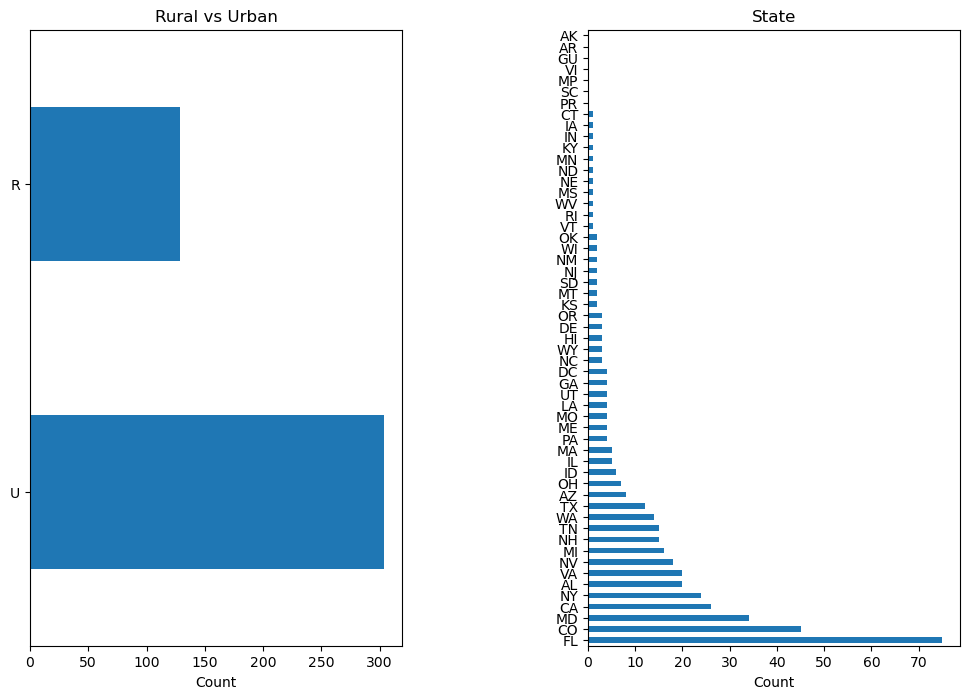

In [53]:
df_dict[procedure]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
df_dict[procedure]['Rural Versus Urban'].value_counts().plot(kind='barh', ax=ax[0])
ax[0].set_title('Rural vs Urban')
ax[0].set_xlabel('Count')
df_dict[procedure]['State Code'].value_counts().plot(kind='barh', ax=ax[1])
ax[1].set_title('State')
ax[1].set_xlabel('Count')
plt.subplots_adjust(wspace=0.5);

We have more urban hospitals than rural hospitals when it comes to __CPT 58150__ and seems like most values come from Florida and Colorado. I would expect most values from California or New York just because those are the most populous states. However, this could be either be due to the JSON files that selected (I personally picked smaller files to parse given my CPU limitations), where United Healthcare does most of its business (insurance companies have varied popularity state-to-state), or some function of both.

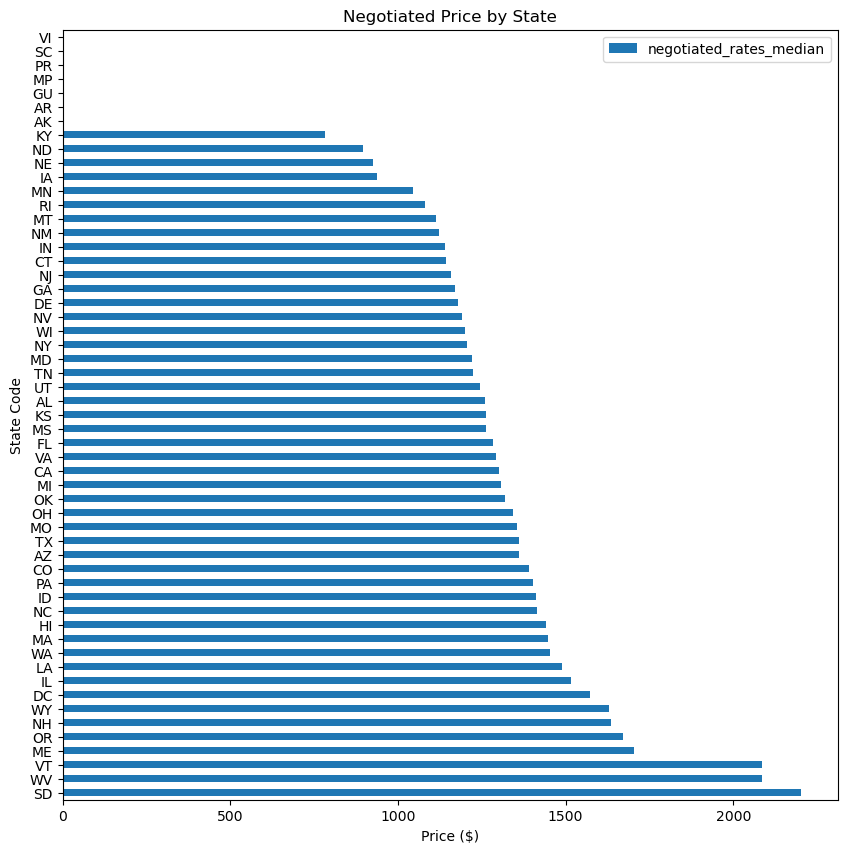

In [54]:
state_price_means = df_dict[procedure].groupby(by='State Code')[['negotiated_rates_median']].mean()
(state_price_means.reindex(index=state_price_means.mean(axis=1)
    .sort_values(ascending=False)
    .index)
    .plot(kind='barh', figsize=(10, 10), title='Negotiated Price by State'))
plt.xlabel('Price ($)');

Seems like the most expensive states are more rural in general. South Dakota, West Virginia, Maine, Vermont, Oregon, New Hampshire, and Wyoming.  Lets us better visualize this.

In [55]:
prices = pd.melt(df_dict[procedure][['State Code', 'negotiated_rates_median']], 
                        id_vars='State Code', 
                        var_name='rate', 
                        value_vars=['negotiated_rates_median'], 
                        value_name='Price')
prices.head()

,State Code,rate,Price
0,NV,negotiated_rates_median,1183.030
1,NV,negotiated_rates_median,1153.145
2,NV,negotiated_rates_median,1013.590
3,OH,negotiated_rates_median,949.300
4,FL,negotiated_rates_median,1205.165


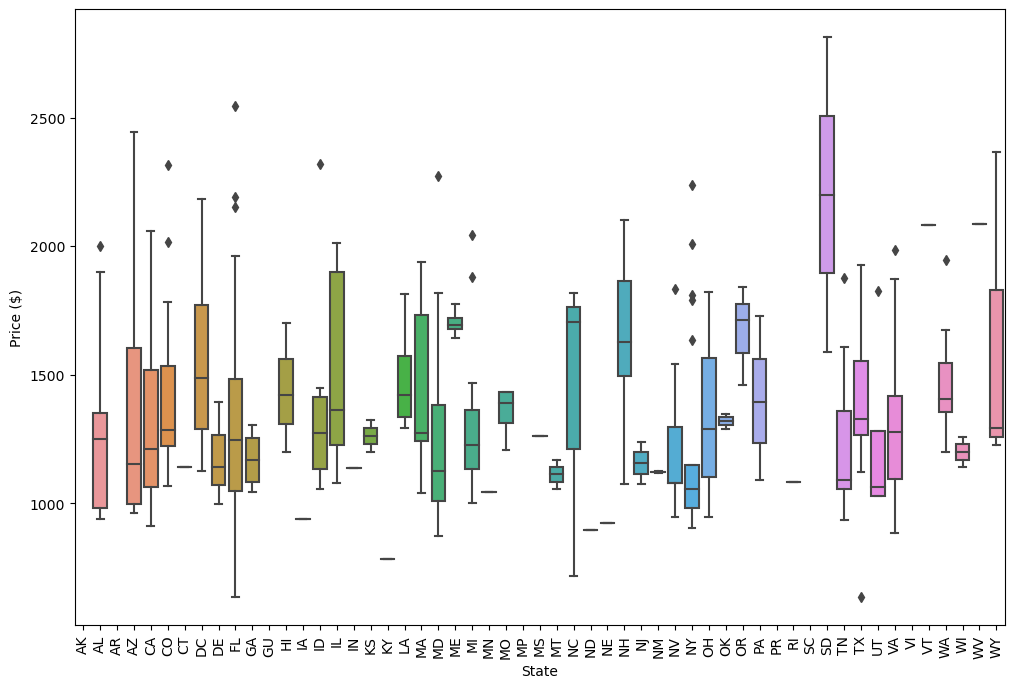

In [56]:
plt.subplots(figsize=(12, 8))
sns.boxplot(x='State Code', y='Price', data=prices)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State');

In general, the more rural states have more expensive fees. States that have a good mix of both rural and urban settings, like Pennsylvania, Ohio, lie somewhere in the middle. Places like New York, where most people, and I imagine hospitals, live in urban areas, the negotiated price tends to be lower. However, this is not always the case- cities like Washington DC did register higher prices.

Let us see if this assumption is true by taking a look at the urban hospitals vs rural hospitals.

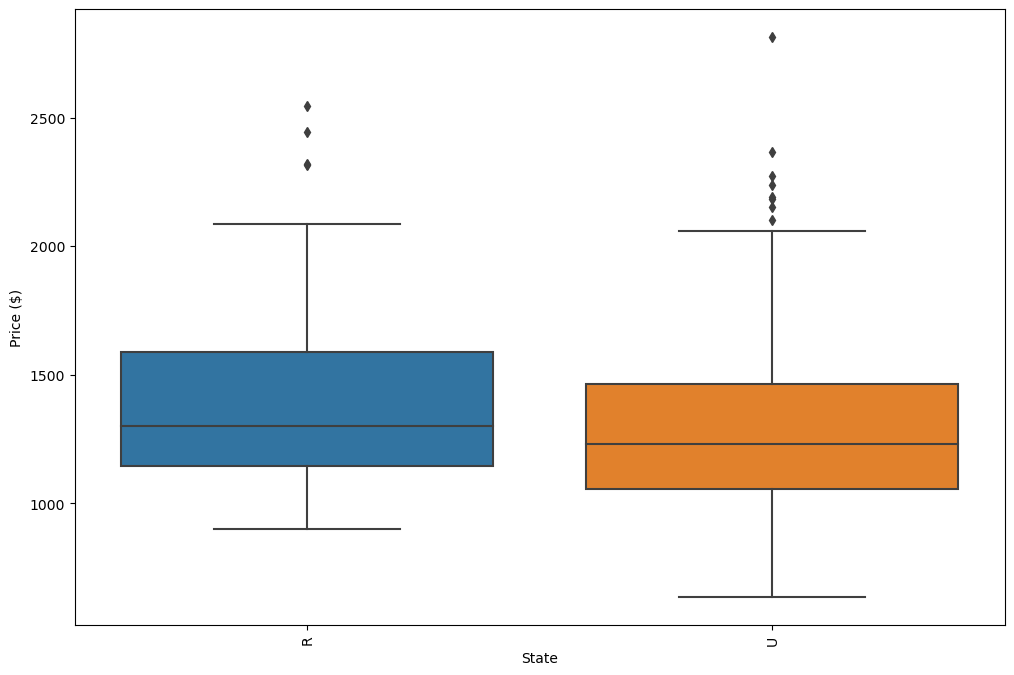

In [57]:
prices_ur = pd.melt(df_dict[procedure][['Rural Versus Urban', 'negotiated_rates_median']], 
                        id_vars='Rural Versus Urban', 
                        var_name='rate', 
                        value_vars=['negotiated_rates_median'], 
                        value_name='Price')
plt.subplots(figsize=(12, 8))
sns.boxplot(x='Rural Versus Urban', y='Price', data=prices_ur)
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)')
plt.xlabel('State');

Seems our hypothesis is correct, rural hospitals tend to have higher negotiated rates than urban ones. Whether this is due to demand or some other factor is yet to be seen. Let as take a closer look at the procedure selected.

In [58]:
df_dict[procedure].describe().T

,count,mean,std,min,25%,50%,75%,max
PSI_03,433.0,0.673386,0.810991,0.012772,0.158022,0.407242,0.871639,5.677306
PSI_06,433.0,0.185660,0.028688,0.101621,0.169259,0.182754,0.195157,0.313581
PSI_08,433.0,0.073720,0.036245,0.020105,0.050516,0.066071,0.084833,0.253857
PSI_09,433.0,2.359540,0.366676,1.292758,2.162745,2.342020,2.503747,4.211885
PSI_10,433.0,0.915519,0.291258,0.306265,0.782009,0.887685,0.915519,3.064857
PSI_11,433.0,6.713860,3.188978,1.316736,4.713521,6.475573,7.693963,28.983164
PSI_12,433.0,3.469364,0.768233,1.673657,2.987383,3.454754,3.807659,7.738493
PSI_13,433.0,4.169867,0.953533,1.654113,3.660041,4.124606,4.513659,8.703087
PSI_14,433.0,0.799425,0.177501,0.389364,0.706171,0.764820,0.799425,1.975858
PSI_15,433.0,1.070740,0.349972,0.386568,0.851059,0.996867,1.207280,2.562261


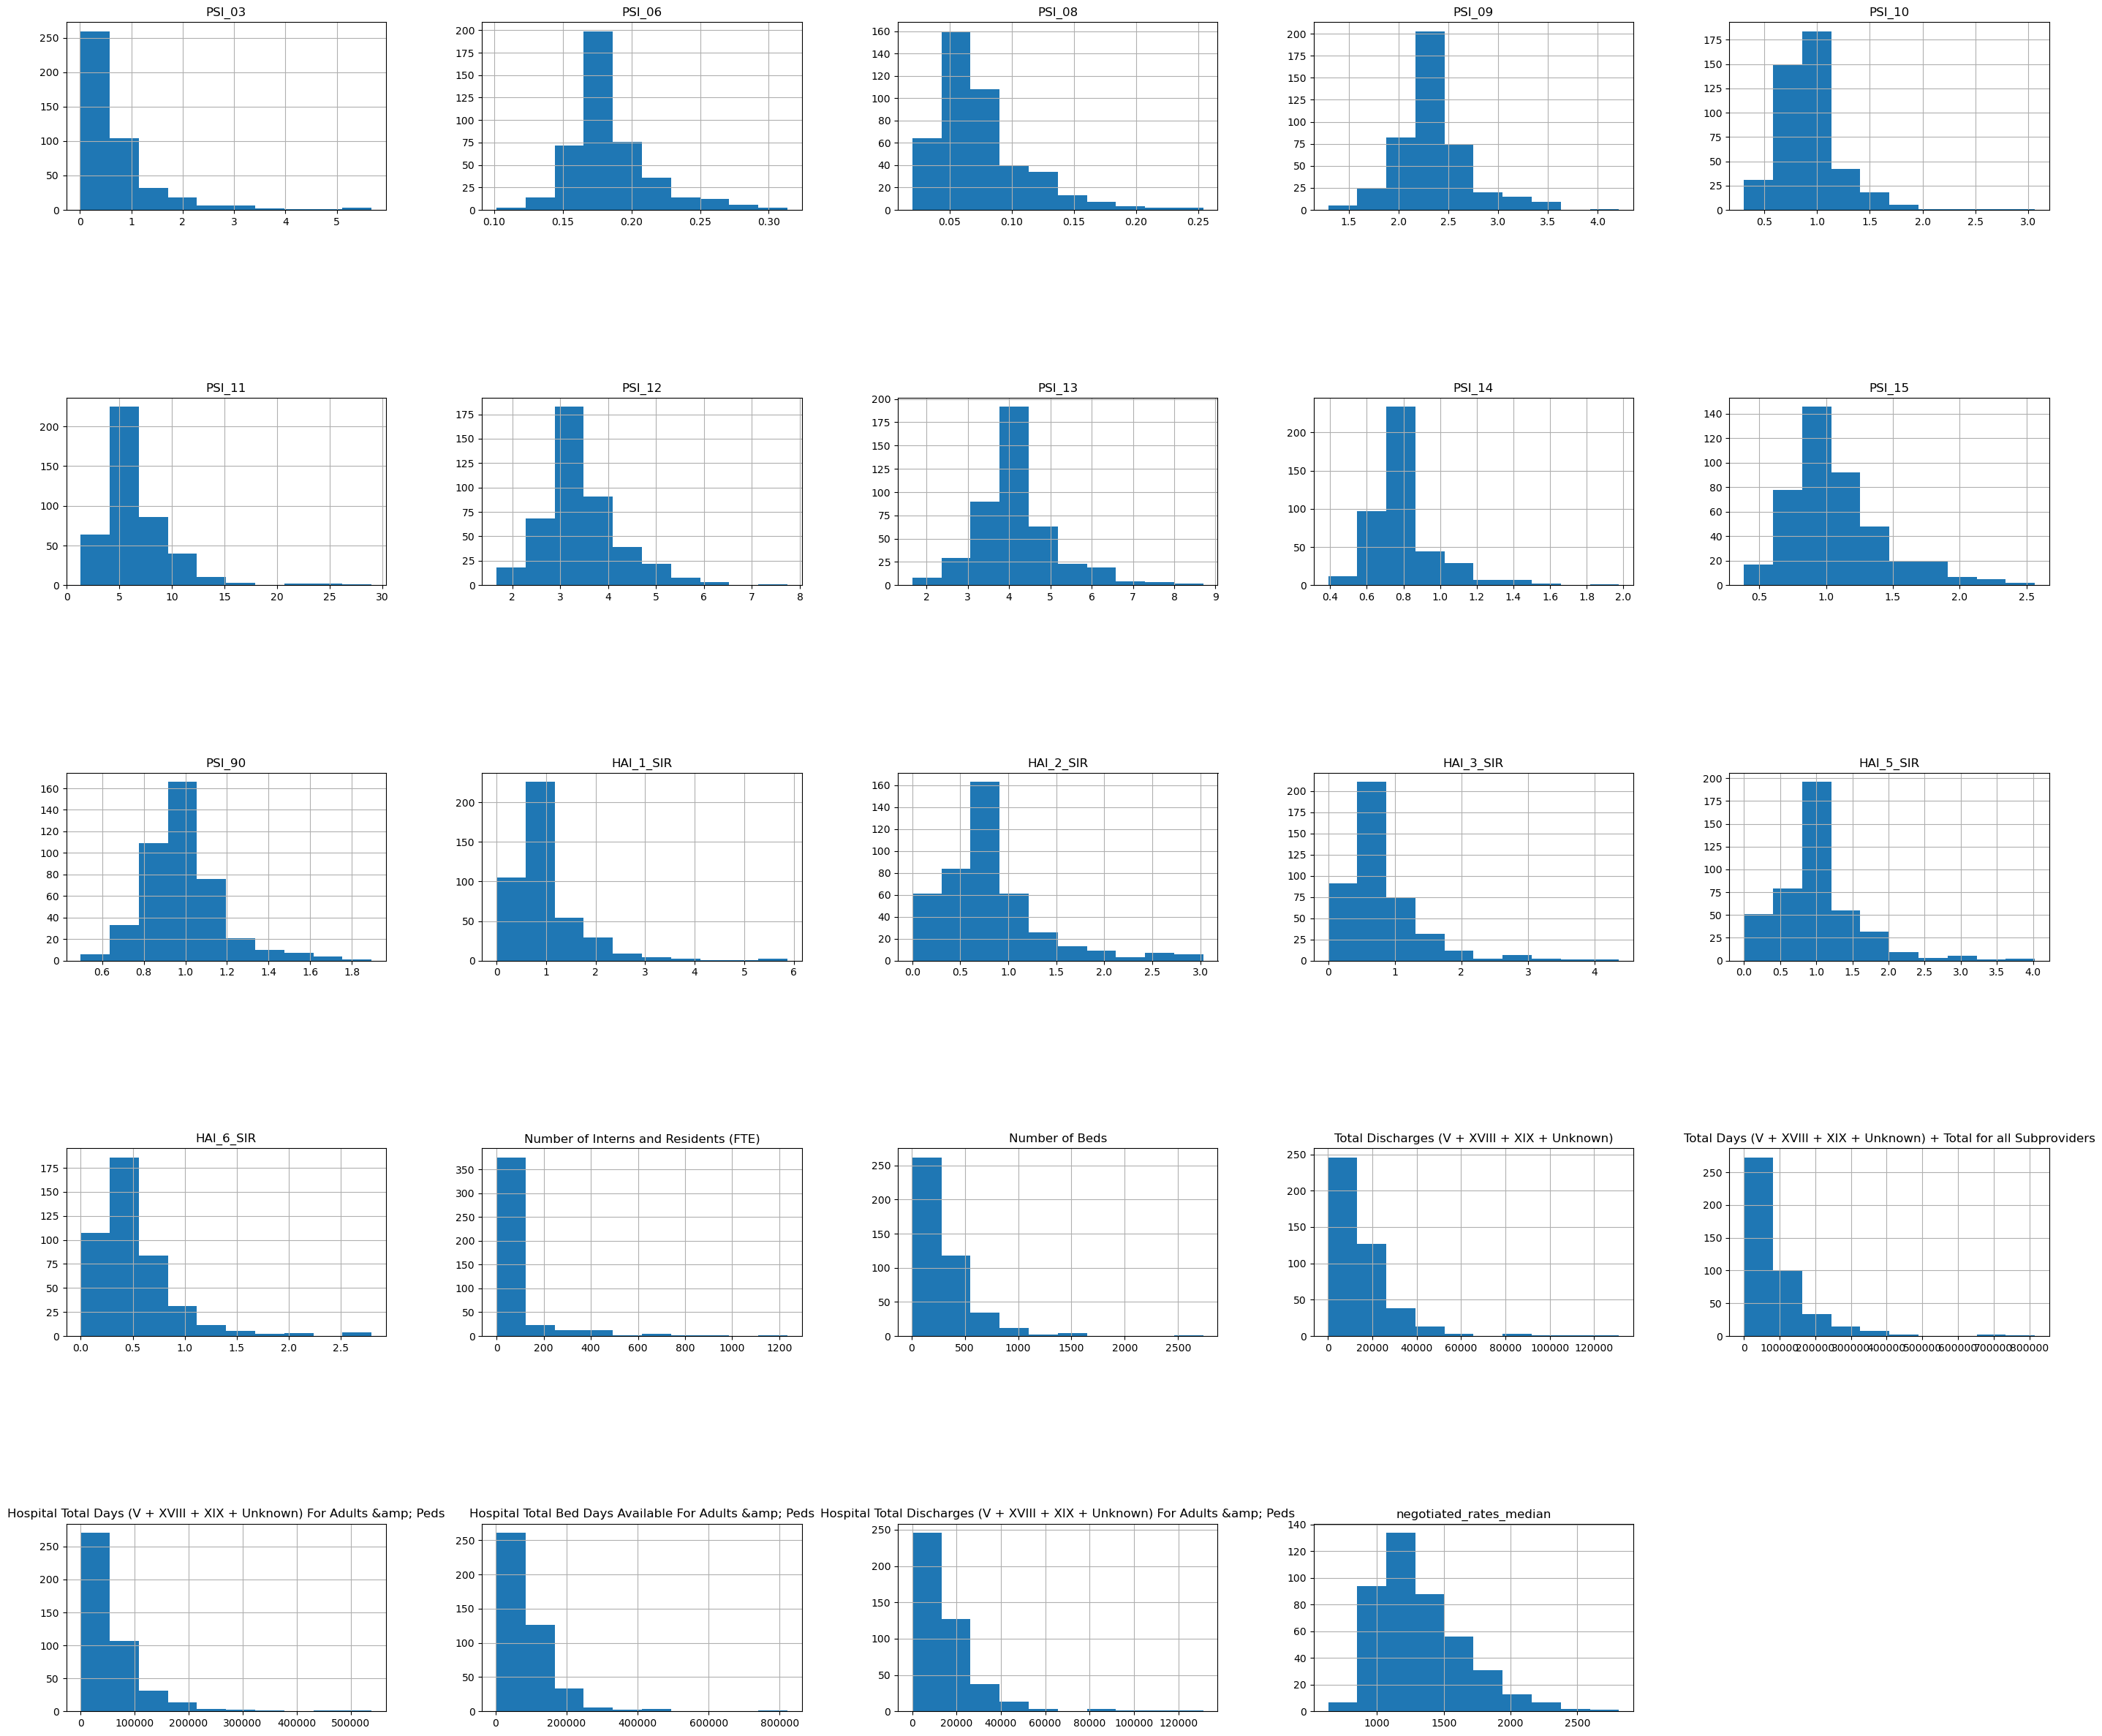

In [59]:
df_dict[procedure].hist(figsize=(35,30))
plt.subplots_adjust(hspace=1);

Negotiated Rates skew right, which is similar to most safety/infection ratings. Cost variables tend to vary. 

Let us take a deeper dive into state variables by gather some basic state statistics. First let us try to get population data from wikipedia.

In [60]:
states_url = 'https://simple.wikipedia.org/w/index.php?title=List_of_U.S._states&oldid=7168473'
usa_states = pd.read_html(states_url)
usa_states = usa_states[0]
usa_states_sub = usa_states.iloc[:, [0,1,5]].copy()
usa_states_sub.columns = ['state','code','state_population']
usa_states_sub.state.replace(to_replace='\[.*\]', value='', regex=True, inplace=True)
usa_states_sub.state.replace(to_replace='\ʻ', value='', regex=True, inplace=True)
usa_states_sub.state[usa_states_sub.state.str.contains('Massachusetts|Pennsylvania|Rhode Island|Virginia|Hawaii')]
usa_states_sub.loc[len(usa_states_sub.index)] = ['Washington, D.C.', 'DC', 712_816]
usa_states_sub.tail()

,state,code,state_population
46,Washington,WA,7614893
47,West Virginia,WV,1792147
48,Wisconsin,WI,5822434
49,Wyoming,WY,578759
50,"Washington, D.C.",DC,712816


In addition let us try to house income data per state. This might explain the discrepancy between prices espeically for cities like Washington DC, or this might be negatively correlated with negotiated prices- as I imagine urban areas have higher incomes and lower negotiated prices and visa vera for rural areas.

In [61]:
income_url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_income#States_and_territories_ranked_by_median_household_income'
income = pd.read_html(income_url)
income = income[1]
income_state = income.iloc[:,[1,2]].copy()
income_state.columns = ['state','salary']
income_state['salary'] = income_state['salary'].str.replace(r'\D','')
income_state['salary'] = income_state['salary'].astype('int')
income_state.head()
state_df = usa_states_sub.merge(income_state,how='left',on='state');

C:\Users\Vignesh Selvakumaran\AppData\Local\Temp\ipykernel_12604\2239605267.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  income_state['salary'] = income_state['salary'].str.replace(r'\D','')


Let us take a quick look at the data.

In [62]:
state_df.head()

,state,code,state_population,salary
0,Alabama,AL,4903185,51734
1,Alaska,AK,731545,75463
2,Arizona,AZ,7278717,62055
3,Arkansas,AR,3017804,48952
4,California,CA,39512223,80440


In addition, I have compiled an excel of all the hospital demand/cost metrics aggregated by state online. let us import that here.

In [63]:
state_hospital_path = 'Hospital_Metrics\state_metrics.xlsx'
hospital = pd.read_excel(state_hospital_path)
hospital.drop(hospital.index[0], axis=0, inplace=True)
hospital[['code','State']]=hospital['State'].str.split('-',expand=True)
hospital.drop(['State','Gross Patient', 'Patient'], axis=1, inplace=True)
hospital['code']= hospital['code'].str.strip()
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 1 to 57
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Number   57 non-null     float64
 1   Staffed  57 non-null     float64
 2   Total    57 non-null     float64
 3   code     57 non-null     object 
dtypes: float64(3), object(1)
memory usage: 1.9+ KB


Let us merge all of this data together. We will merge left on state code.

In [64]:
state_df = state_df.merge(hospital,how='left',on='code')
state_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   state             51 non-null     object 
 1   code              51 non-null     object 
 2   state_population  51 non-null     int64  
 3   salary            51 non-null     int32  
 4   Number            51 non-null     float64
 5   Staffed           51 non-null     float64
 6   Total             51 non-null     float64
dtypes: float64(3), int32(1), int64(1), object(2)
memory usage: 3.0+ KB


Let us relabel the columns so they are easy to use. In addition, let us use the describe method on this dataframe.

In [65]:
state_df.columns = ['state','code','state population','median salary','total hospitals','total beds','total discharges']
state_df.describe().T

,count,mean,std,min,25%,50%,75%,max
state population,51.0,6.436207e+06,7.360551e+06,578759.0,1789606.0,4467673.0,7446805.0,39512223.0
median salary,51.0,6.551131e+04,1.117134e+04,45792.0,57506.0,63229.0,75028.0,92266.0
total hospitals,51.0,7.552941e+01,7.488107e+01,7.0,25.0,59.0,93.0,368.0
total beds,51.0,1.448333e+04,1.628124e+04,867.0,3521.0,10006.0,17283.0,74451.0
total discharges,51.0,5.892028e+05,6.704647e+05,30055.0,135038.5,391876.0,682192.5,2971759.0


Let us double check and make sure our assumptions are correct about the dataframe. California and Texas should have the largest population.

In [66]:
state_summary_newind = state_df.set_index('state')
state_summary_newind['state population'].sort_values(ascending=False).head()

state
California      39512223
Texas           28995881
Florida         21477737
New York        19453561
Pennsylvania    12801989
Name: state population, dtype: int64

Let us take a look at median salary. We would expect this to be high in places like Washington DC and other states that are more urban.

In [67]:
state_summary_newind['median salary'].sort_values(ascending=False).head()

state
Washington, D.C.    92266
Maryland            86738
Massachusetts       85843
New Jersey          85751
Hawaii              83102
Name: median salary, dtype: int32

Similarly let us take a look at total beds. I would expect this to line up with population.

In [68]:
state_summary_newind['total beds'].sort_values(ascending=False).head()

state
California      74451.0
Texas           59982.0
New York        57647.0
Florida         57018.0
Pennsylvania    35179.0
Name: total beds, dtype: float64

I would also expect total discharges to line up with the above list, granted much larger numbers than hospital beds.

In [69]:
state_summary_newind['total discharges'].sort_values(ascending=False).head()

state
California      2971759.0
Texas           2692861.0
Florida         2487846.0
New York        2060633.0
Pennsylvania    1381180.0
Name: total discharges, dtype: float64

Let us make some features that take into account the ratio of how much a random hospital services within its state. This can be done by dividing hospital demand metrics (hospitals within a state, total beds within a state, discharges within a state) by the population of the state. To make the numbers a little bit easier to understand, I will do it per 100k capita.

In [70]:
state_df['hospitals_per_100kcapita'] = 100_000 * state_df['total hospitals']/ state_df['state population']
state_df['beds_per_100kcapita'] = 100_000 * state_df['total beds']/ state_df['state population']
state_df['discharges_per_100kcapita'] = 100_000 * state_df['total discharges']/ state_df['state population']
state_df.head()

,state,code,state population,median salary,total hospitals,total beds,total discharges,hospitals_per_100kcapita,beds_per_100kcapita,discharges_per_100kcapita
0,Alabama,AL,4903185,51734,90.0,15046.0,526562.0,1.835542,306.861764,10739.182796
1,Alaska,AK,731545,75463,11.0,1288.0,44563.0,1.503667,176.065724,6091.627993
2,Arizona,AZ,7278717,62055,76.0,13870.0,600818.0,1.044140,190.555561,8254.449239
3,Arkansas,AR,3017804,48952,52.0,7859.0,306902.0,1.723107,260.421154,10169.712811
4,California,CA,39512223,80440,336.0,74451.0,2971759.0,0.850370,188.425237,7521.113150


Let us take a preliminary look at the state data.

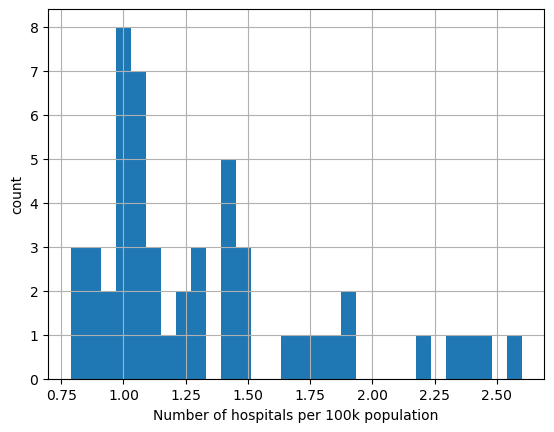

In [71]:
state_df['hospitals_per_100kcapita'].hist(bins=30)
plt.xlabel('Number of hospitals per 100k population')
plt.ylabel('count');

Looks like all the hospitals fall within ~0.75 to 2.75 beds per 100k capita. The number of hospital beds per capita being within a close range is reassuring that this data lines up.

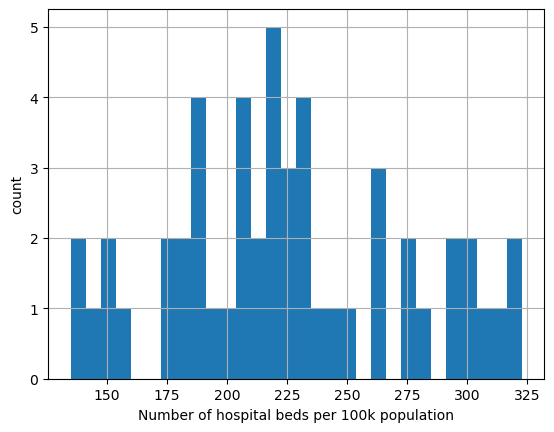

In [72]:
state_df['beds_per_100kcapita'].hist(bins=30)
plt.xlabel('Number of hospital beds per 100k population')
plt.ylabel('count');

Similarly the number of hospital beds makes intuitive sense as well.

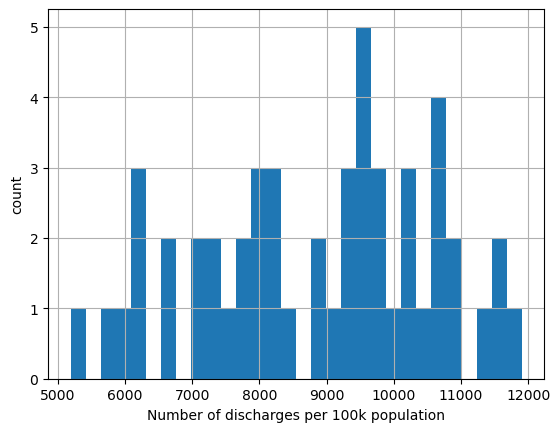

In [73]:
state_df['discharges_per_100kcapita'].hist(bins=30)
plt.xlabel('Number of discharges per 100k population')
plt.ylabel('count');

The wider range of values here tends to make more sense as you take into account discharges is probably heavily influenced by population.

Let us take a look at what are the lower and values for these states and the higher end values. This might give us some insight on what to explore next.

In [74]:
state_df.set_index('state')['hospitals_per_100kcapita'].sort_values(ascending=False).head()

state
South Dakota    2.599872
Wyoming         2.418969
Louisiana       2.387716
Mississippi     2.352033
Oklahoma        2.223923
Name: hospitals_per_100kcapita, dtype: float64

As expected, these are mostly rural states. I imagine more hospitals per capita just because of transportation limitations.

In [75]:
state_df.set_index('state')['beds_per_100kcapita'].sort_values(ascending=False).head()

state
Mississippi         322.766098
Louisiana           316.619751
South Dakota        316.167020
Alabama             306.861764
Washington, D.C.    303.163790
Name: beds_per_100kcapita, dtype: float64

It is slightly surprising that Washington DC is on this list. In addition, I would have expected more urban states to dominate this list because the hospitals would be in more demand, but that is not the case. This may be due to space limitations.

In [76]:
state_df.set_index('state')['discharges_per_100kcapita'].sort_values(ascending=False).head()

state
Washington, D.C.    11902.931472
Florida             11583.371190
Kentucky            11462.096711
Tennessee           11261.830494
West Virginia       10794.538618
Name: discharges_per_100kcapita, dtype: float64

This is surprising that Washington DC would dominate this list followed by mixed states like Florida and Tennessee. There could be a variety of factors at play here, from utilization of hospitals, to overall health of citizens, and even disposable income.

To get a better overview of the state data, let us take a look at the scaled data.

In [77]:
state_summary_scale = state_df.drop(columns=['state']).set_index('code')
state_summary_index = state_summary_scale.index
state_summary_columns = state_summary_scale.columns
state_summary_scale = scale(state_summary_scale)

state_summary_scaled_df = pd.DataFrame(state_summary_scale, columns=state_summary_columns)
state_summary_scaled_df.head()

,state population,median salary,total hospitals,total beds,total discharges,hospitals_per_100kcapita,beds_per_100kcapita,discharges_per_100kcapita
0,-0.210348,-1.245544,0.195171,0.034903,-0.094359,1.124854,1.649280,1.111777
1,-0.782744,0.899687,-0.870334,-0.818527,-0.820415,0.395693,-0.999074,-1.617255
2,0.115602,-0.312470,0.006347,-0.038046,0.017497,-0.613931,-0.705684,-0.347252
3,-0.469043,-1.497052,-0.317350,-0.410918,-0.425242,0.877825,0.708952,0.777385
4,4.538402,1.349635,3.513070,3.719887,3.588950,-1.039663,-0.748819,-0.777865


Let us take a look at the mean and confirm that it is close to 0. If so, the scaling as been applied correctly.

In [78]:
state_summary_scaled_df.mean()

state population             2.394599e-17
median salary                2.612289e-17
total hospitals              6.530724e-18
total beds                  -3.483053e-17
total discharges            -4.353816e-17
hospitals_per_100kcapita    -2.133370e-16
beds_per_100kcapita          1.001378e-16
discharges_per_100kcapita    2.351061e-16
dtype: float64

Similarly, we can check the standard deviation. This should be around 1.

In [79]:
state_summary_scaled_df.std(ddof=0)

state population             1.0
median salary                1.0
total hospitals              1.0
total beds                   1.0
total discharges             1.0
hospitals_per_100kcapita     1.0
beds_per_100kcapita          1.0
discharges_per_100kcapita    1.0
dtype: float64

We can use PCA to determine which statistics explain the variance within our __state_summary_scale__

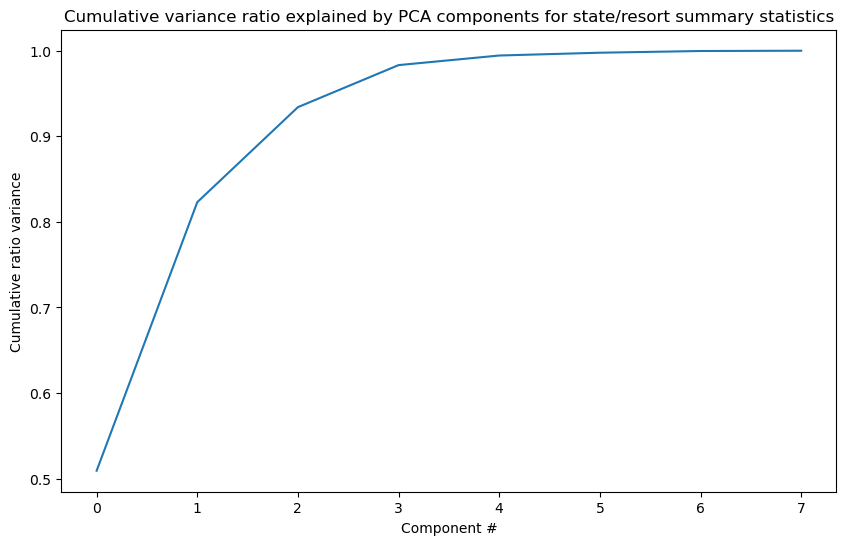

In [80]:
state_pca = PCA().fit(state_summary_scale)
plt.subplots(figsize=(10, 6))
plt.plot(state_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for state/resort summary statistics');

It looks like the elbow occurs around 3 components.

In [81]:
state_pca_x = state_pca.transform(state_summary_scale)
state_pca_x.shape

(51, 8)

Lets take our top two components from PCA to determine how much they explain hospital summary statistics.

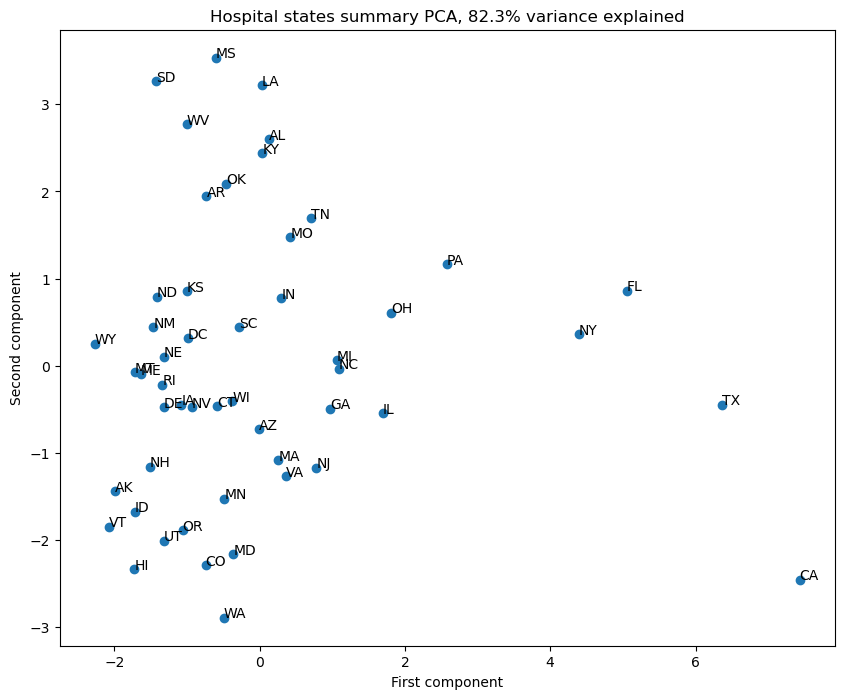

In [82]:
x = state_pca_x[:, 0]
y = state_pca_x[:, 1]
state = state_summary_index
pc_var = 100 * state_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Hospital states summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))

Let us revisit our United Healthcare dataset before we combine both datasets.

In [83]:
df_dict[procedure].head()

,ccn,State Code,Rural Versus Urban,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,PSI_12,...,HAI_5_SIR,HAI_6_SIR,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,negotiated_rates_median
0,290003,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,9.818181,2.791577,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1183.030
1,290039,NV,U,0.282079,0.198471,0.107206,2.010451,0.816337,15.563100,2.026761,...,0.597,0.066,123.97,363.0,22906.758242,126428.379121,89786.991758,106872.802198,22906.758242,1153.145
2,290007,NV,U,0.043938,0.163886,0.051103,2.250363,1.452640,3.166647,3.318041,...,2.011,0.685,221.14,498.0,22271.000000,118028.000000,78857.000000,131028.000000,22271.000000,1013.590
3,360144,OH,U,0.068078,0.240431,0.060184,2.240059,0.885788,4.068711,4.103549,...,0.000,0.336,34.48,172.0,7405.288462,35116.208791,30164.642857,53802.403846,7405.288462,949.300
4,100168,FL,U,2.915921,0.197895,0.062805,3.227263,3.064857,10.679905,5.434220,...,0.585,0.440,69.78,370.0,17098.846154,93744.835165,69105.329670,117714.505495,17098.846154,1205.165


Lets take a look at negotiated rates by state.

In [84]:
state_avg_price = df_dict[procedure].groupby(by='State Code')['negotiated_rates_median'].mean()
state_avg_price.head()

State Code
AK            NaN
AL    1259.603250
AR            NaN
AZ    1362.460625
CA    1300.924038
Name: negotiated_rates_median, dtype: float64

Lets take a look at the distribution of negotiated prices by state.

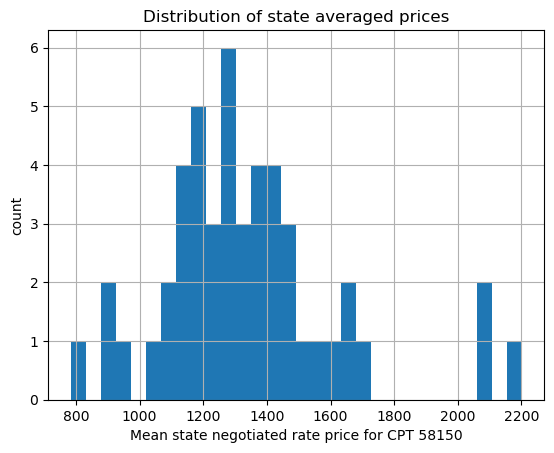

In [85]:
state_avg_price.hist(bins=30)
plt.title('Distribution of state averaged prices')
plt.xlabel('Mean state negotiated rate price for ' + procedure)
plt.ylabel('count');

We will obtain the PCA values for each state, focusing on the 2 that explain the most variance.

In [86]:
pca_df = pd.DataFrame({'PC1': state_pca_x[:, 0], 'PC2': state_pca_x[:, 1]}, index=state_summary_index)
pca_df.head()

,PC1,PC2
code,,
AL,0.133273,2.601814
AK,-1.993006,-1.440596
AZ,-0.004479,-0.725224
AR,-0.732544,1.944761
CA,7.432432,-2.454823


Let us revisit our average price per state.

In [87]:
state_avg_price.to_frame().head()

,negotiated_rates_median
State Code,
AK,NaN
AL,1259.603250
AR,NaN
AZ,1362.460625
CA,1300.924038


Let us combine our PCA values we created with state prices to see if we can group like states together to garner a trend in the data.

In [88]:
pca_df = pd.concat([pca_df, state_avg_price], axis=1)
pca_df.head()

,PC1,PC2,negotiated_rates_median
AL,0.133273,2.601814,1259.603250
AK,-1.993006,-1.440596,NaN
AZ,-0.004479,-0.725224,1362.460625
AR,-0.732544,1.944761,NaN
CA,7.432432,-2.454823,1300.924038


One method would be to create quartiles with the data based on negotiated prices and see where data points lie based on PCA data.

In [89]:
pca_df['Quartile'] = pd.qcut(pca_df['negotiated_rates_median'], q=4, precision=1)
pca_df.head()

,PC1,PC2,negotiated_rates_median,Quartile
AL,0.133273,2.601814,1259.603250,"(1176.5, 1297.0]"
AK,-1.993006,-1.440596,NaN,NaN
AZ,-0.004479,-0.725224,1362.460625,"(1297.0, 1442.8]"
AR,-0.732544,1.944761,NaN,NaN
CA,7.432432,-2.454823,1300.924038,"(1297.0, 1442.8]"


In [90]:
pca_df['negotiated_rates_median'].fillna(pca_df['negotiated_rates_median'].mean(), inplace=True)
pca_df['Quartile'] = pca_df['Quartile'].cat.add_categories('NA')
pca_df['Quartile'].fillna('NA', inplace=True)

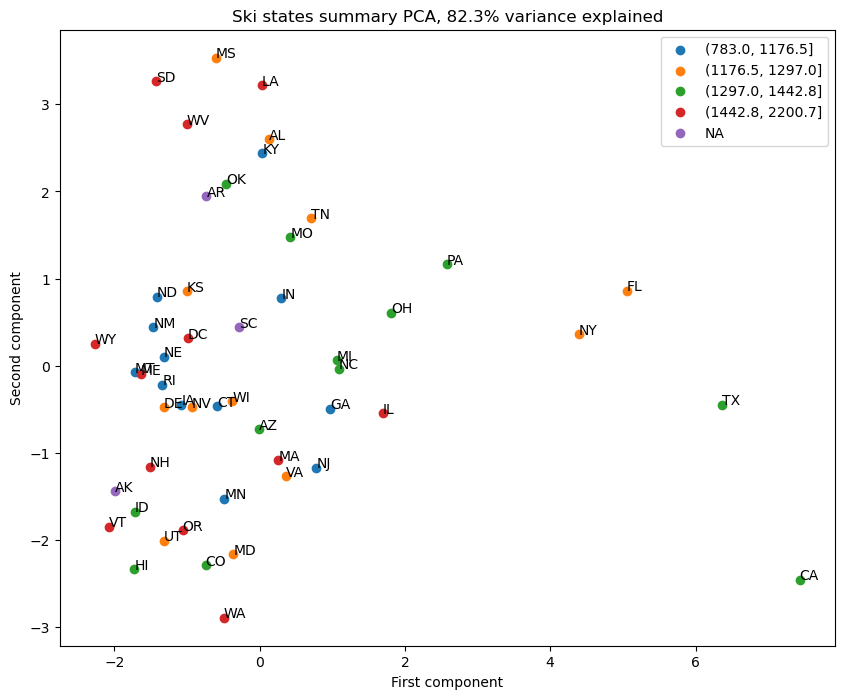

In [91]:
x = pca_df.PC1
y = pca_df.PC2
price = pca_df['negotiated_rates_median']
quartiles = pca_df['Quartile']
state = pca_df.index
pc_var = 100 * state_pca.explained_variance_ratio_.cumsum()[1]
fig, ax = plt.subplots(figsize=(10,8))
for q in quartiles.cat.categories:
    im = quartiles == q
    ax.scatter(x=x[im], y=y[im], label=q)
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
plt.legend()
ax.set_title(f'Ski states summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))

Interestingly, green data points and blue data points tend to lie together and most data points have a near neighbor that is within the same quartile. I do not see an obvious trend here.

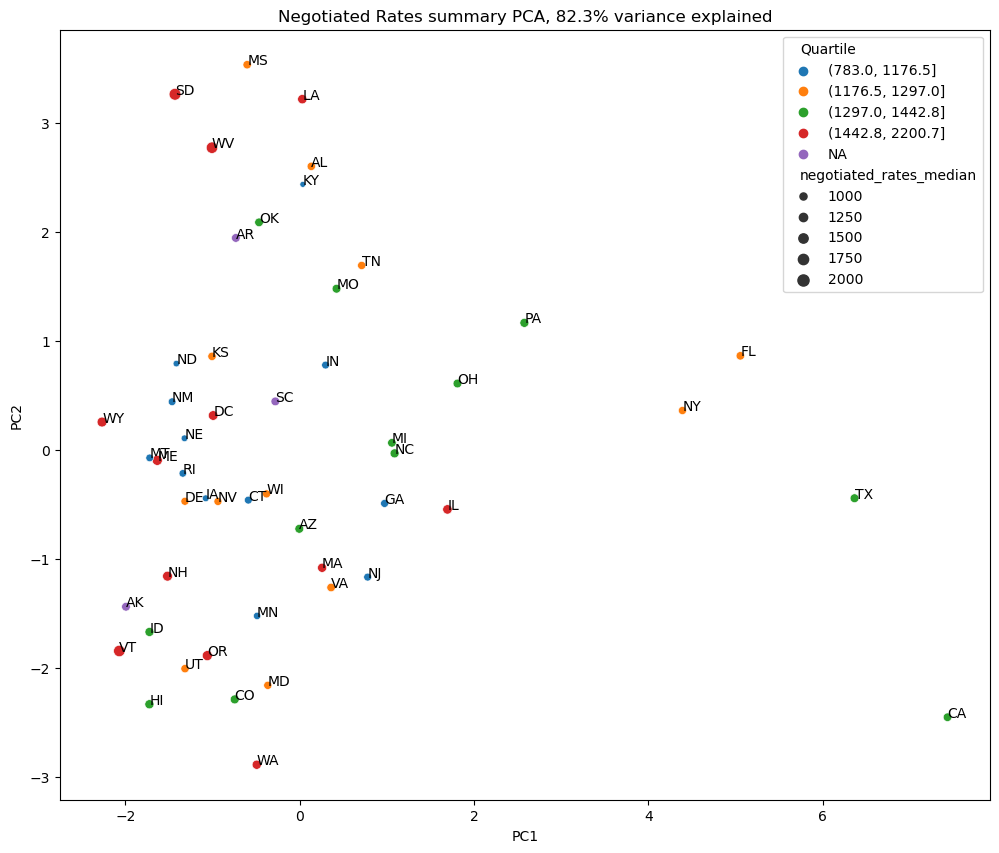

In [92]:
x = pca_df.PC1
y = pca_df.PC2
state = pca_df.index
plt.subplots(figsize=(12, 10))
# Note the argument below to make sure we get the colors in the ascending
# order we intuitively expect!
sns.scatterplot(x=x, y=y, size=pca_df['negotiated_rates_median'], hue=pca_df.Quartile, 
                hue_order=pca_df['Quartile'].cat.categories, data=pca_df)
#and we can still annotate with the state labels
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))   
plt.title(f'Negotiated Rates summary PCA, {pc_var:.1f}% variance explained');

A similar observation is made here.

In [93]:
pd.DataFrame(state_pca.components_, columns=state_summary_columns)

,state population,median salary,total hospitals,total beds,total discharges,hospitals_per_100kcapita,beds_per_100kcapita,discharges_per_100kcapita
0,0.482801,0.021540,0.481041,0.491716,0.492595,-0.117295,0.082744,0.173204
1,-0.100041,-0.465114,0.021603,-0.011698,-0.031521,0.491395,0.561389,0.464153
2,-0.112551,0.560914,-0.184085,-0.043843,-0.051686,-0.434735,0.368593,0.556211
3,0.077993,0.663862,0.076420,0.034021,-0.001829,0.638015,0.239530,-0.285949
4,0.011063,-0.158007,-0.299890,0.258559,0.052265,-0.306497,0.630119,-0.569563
5,0.017479,0.013720,-0.744622,0.406129,0.345207,0.233494,-0.276507,0.173086
6,0.856680,-0.050523,-0.273800,-0.250024,-0.347193,0.008458,0.035849,0.064567
7,-0.061772,0.012707,0.095091,0.678744,-0.715010,0.013542,-0.099847,0.069969


Let us match our state metrics with our df_dictionary.

In [94]:
df_dict[procedure].head()

,ccn,State Code,Rural Versus Urban,PSI_03,PSI_06,PSI_08,PSI_09,PSI_10,PSI_11,PSI_12,...,HAI_5_SIR,HAI_6_SIR,Number of Interns and Residents (FTE),Number of Beds,Total Discharges (V + XVIII + XIX + Unknown),Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders,Hospital Total Days (V + XVIII + XIX + Unknown) For Adults &amp; Peds,Hospital Total Bed Days Available For Adults &amp; Peds,Hospital Total Discharges (V + XVIII + XIX + Unknown) For Adults &amp; Peds,negotiated_rates_median
0,290003,NV,U,0.132660,0.184709,0.114236,1.566620,0.650623,9.818181,2.791577,...,1.091,0.109,31.44,604.0,32823.928571,207129.478022,126462.472527,140216.153846,32823.928571,1183.030
1,290039,NV,U,0.282079,0.198471,0.107206,2.010451,0.816337,15.563100,2.026761,...,0.597,0.066,123.97,363.0,22906.758242,126428.379121,89786.991758,106872.802198,22906.758242,1153.145
2,290007,NV,U,0.043938,0.163886,0.051103,2.250363,1.452640,3.166647,3.318041,...,2.011,0.685,221.14,498.0,22271.000000,118028.000000,78857.000000,131028.000000,22271.000000,1013.590
3,360144,OH,U,0.068078,0.240431,0.060184,2.240059,0.885788,4.068711,4.103549,...,0.000,0.336,34.48,172.0,7405.288462,35116.208791,30164.642857,53802.403846,7405.288462,949.300
4,100168,FL,U,2.915921,0.197895,0.062805,3.227263,3.064857,10.679905,5.434220,...,0.585,0.440,69.78,370.0,17098.846154,93744.835165,69105.329670,117714.505495,17098.846154,1205.165


In [95]:
for p, df_temp in df_dict.items():
    df_temp=df_temp.merge(state_df, how='left',left_on='State Code',right_on='code')
    df_dict[p]= df_temp

In [96]:
df_dict[procedure].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433 entries, 0 to 432
Data columns (total 37 columns):
 #   Column                                                                       Non-Null Count  Dtype   
---  ------                                                                       --------------  -----   
 0   ccn                                                                          433 non-null    category
 1   State Code                                                                   433 non-null    object  
 2   Rural Versus Urban                                                           433 non-null    category
 3   PSI_03                                                                       433 non-null    float64 
 4   PSI_06                                                                       433 non-null    float64 
 5   PSI_08                                                                       433 non-null    float64 
 6   PSI_09                            

In addition, let us make some new features that are related to the ratio of demand features over state features. This would include how many beds our hospital has relative to the state. Same goes for discharges and hospitals.

In [97]:
for p, df_temp in df_dict.items():
    df_temp['hospital_ratio'] = 1/df_temp['total hospitals']
    df_temp['bed_ratio'] = df_temp['Number of Beds']/df_temp['total beds']
    df_temp['discharge_ratio'] = df_temp['Total Days (V + XVIII + XIX + Unknown) + Total for all Subproviders']/df_temp['total discharges']
    df_temp.drop(['state','code'],axis=1,inplace=True)
    df_dict[p]= df_temp

Let us visualize how correlated each feature is to one another, with a focus on negotiated rate.

C:\Users\Vignesh Selvakumaran\AppData\Local\Temp\ipykernel_12604\1729958566.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_dict[procedure].corr());


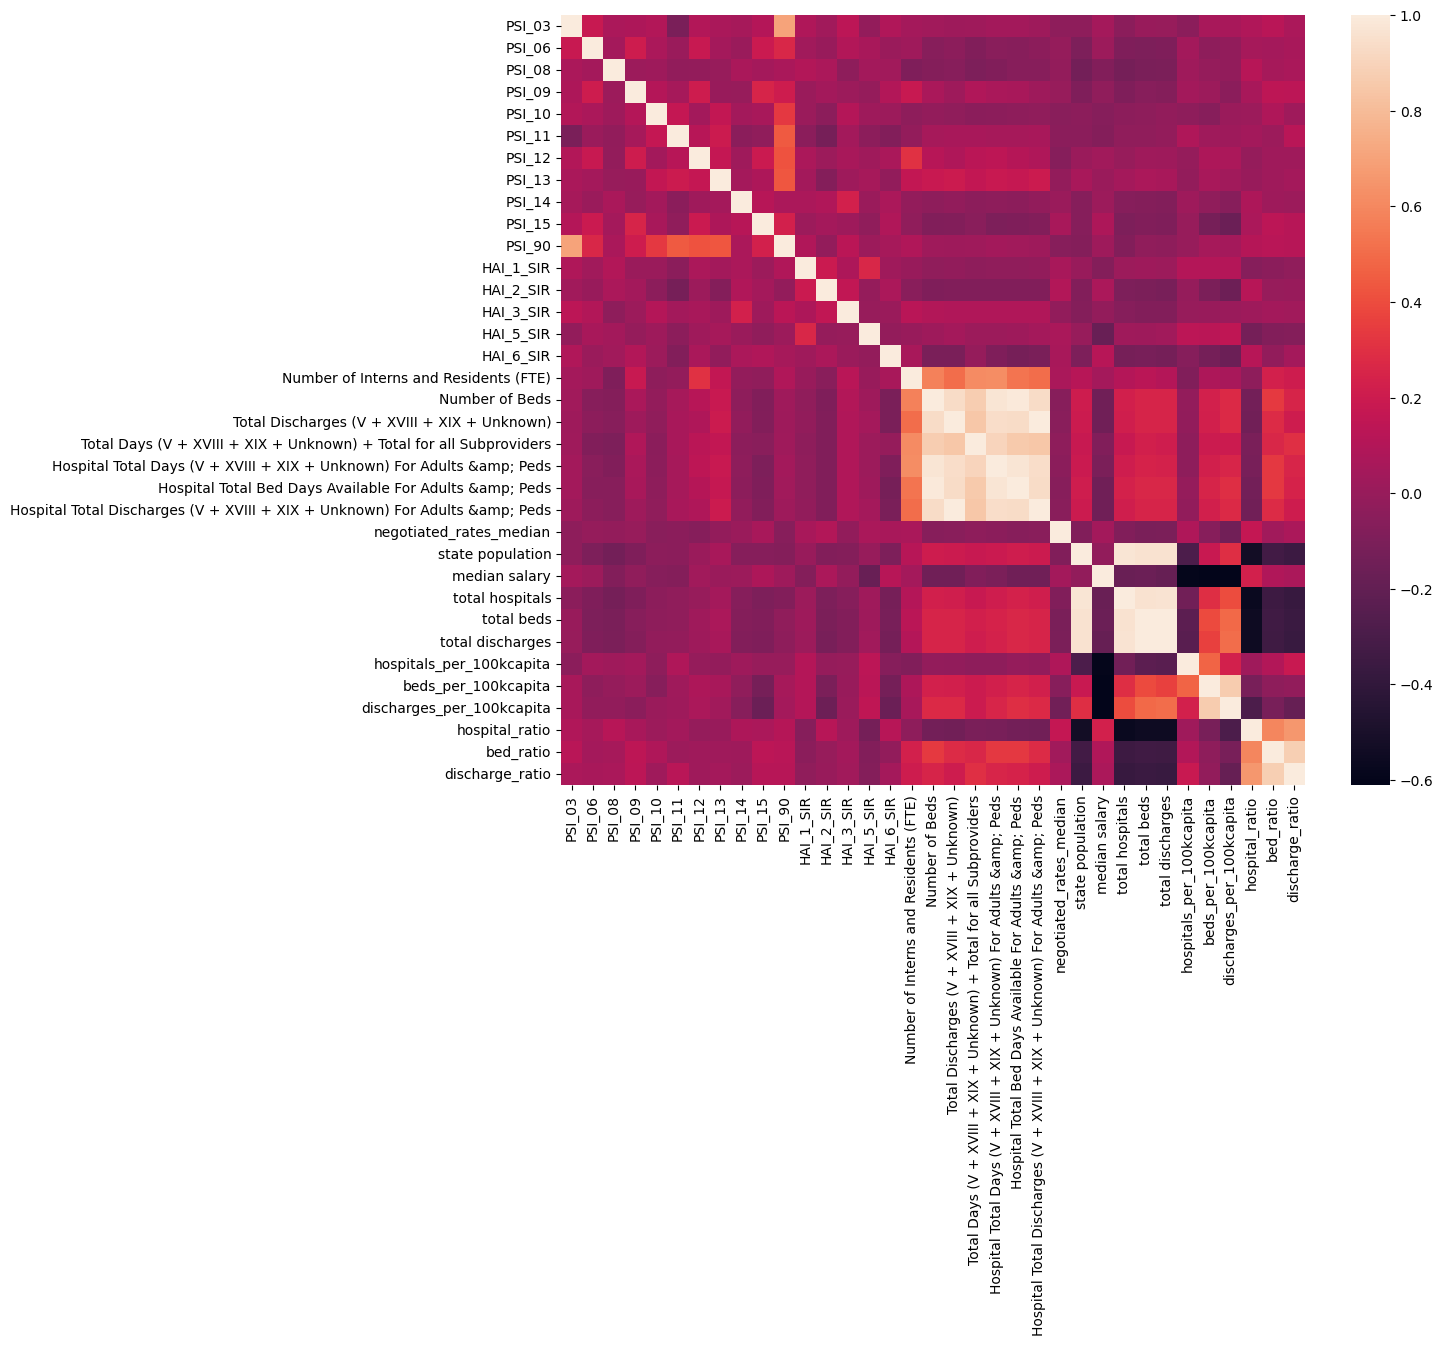

In [98]:
plt.subplots(figsize=(12,10))
sns.heatmap(df_dict[procedure].corr());

Let us compare each variable to negotiated rates to see if we can find a pattern.

In [99]:
def scatterplots(columns, procedure, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'negotiated_rates_median', data=df_dict[procedure], alpha=0.5)
        ax.set(xlabel=col, ylabel='Price')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [100]:
features = [column for column in df_dict[procedure].columns if column not in ['ccn', 'Rural Versus Urban', 'Procedure', 'State Code', 'negotiated_rates_median']]

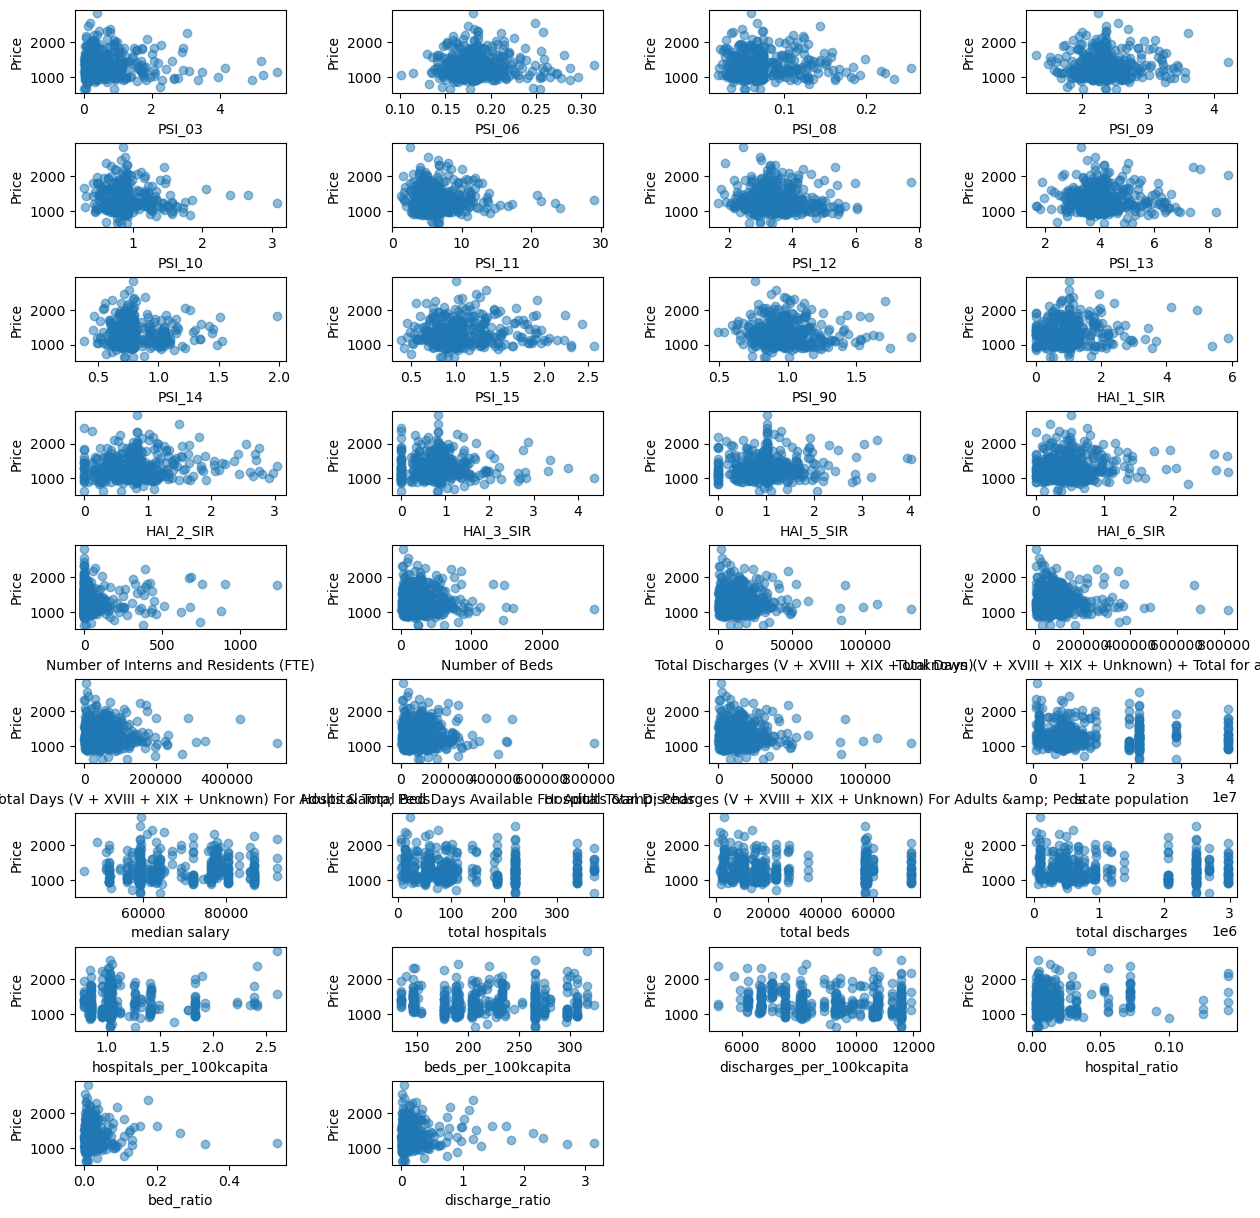

In [101]:
scatterplots(features, procedure, ncol=4, figsize=(15, 15))

Several of the HAI variable alongside total discharges tend to have a negative correlation with negotiated rates; however, it is hard to get a clear picture here.

In the next notebook we will take a closer look at these features and try to pre-process the data to create a model.

For now we will save each of our new created dataframes that contain demand, safety, and infection data for various procedures.

In [102]:
for p, df_temp in df_dict.items():
    p = p.replace(' ','')
    df_temp.to_parquet("data/"+p+'.parquet', engine='pyarrow')

## Conclusion

Throughout this notebook we created dataframe for procedures which we believe might be affected by safety/infection metrics acquired the CMS dataset. We have created tables of features that include these metrics, alongside hospital demand data(discharges, hospital beds, etc). The price was pulled from UHC dataset. We have compiled this dataset and created a dictionary of dataframes associated with each procedure. We visualized the data associated with one procedure that had a relatively higher value of price and a good number of rows. Next, we will pre-process the data for a potential model.